In [1]:
import sys
sys.path.insert(0, "../lib")

In [2]:
import json
import math
import os
import pathlib
import re
import datetime

import scanpy as sc
import numpy as np
import pandas as pd
import sc_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sankey
import statsmodels.stats.multitest
import scipy.stats
import statannotations.Annotator
import statsmodels.api
import sklearn.preprocessing

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [5]:
FONT_DIR = '/projects/b1038/Pulmonary/nmarkov/fonts'
for f in os.listdir(FONT_DIR):
    if f.endswith('.ttf'):
        mpl.font_manager.fontManager.addfont(f'{FONT_DIR}/{f}')

In [6]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
# mpl.rcParams['mathtext.default'] = 'regular'

In [7]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        if pd.api.types.is_numeric_dtype(df[column]):
            values = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
            if not isinstance(palette, mpl.colors.Colormap):
                palette = sns.color_palette(palette, as_cmap=True)
            colors = palette(values)
            colors = [mpl.colors.to_hex(color) for color in colors]
            colors = pd.Series(colors, index=values.index, name=column)
        else:
            lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
            colors = df[column].map(lut)
        result.append(colors)
    return pd.concat(result, axis=1)

# Compute differential abundance and correlation with clinical parameters

## 1. Differential abundance

For each sample for each cell type we compute fraction of that cell type in that sample (e.g. 1000 TRAMs in a sample of 10k cells = 10% TRAMs). Then we test if the distribution of this fraction between samples is different for SSc and control samples with Mann-Whitney U test with FDR correction.

In [8]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [9]:
adata = sc.read_h5ad(DATA / "03_bal-object/03_bal-object.h5ad")

In [10]:
adata.obs.cell_type = adata.obs.cell_type.astype(str).replace({
    'MoAM-3 mature': 'MoAM-2',
    'MoAM-4 profibrotic': 'MoAM-3 profibrotic',
    'gd/NKT cells': 'NK + γδT cells',
    'Perivascular macrophages': 'Interstitial macrophages',
}).astype('category')

In [11]:
adata.obs.Status = pd.Categorical(adata.obs.Status.astype(str).replace({
    'control': 'Control',
    'SSc': 'SSc-ILD'
}), categories=['Control', 'SSc-ILD'])

In [12]:
counts = adata.obs.groupby(
    ["cell_type", "Status", "External Sample ID"],
    observed=True
).count().Study.reset_index()

In [13]:
counts.cell_type = counts.cell_type.astype("category")

In [15]:
counts = counts.sort_values("cell_type")

In [16]:
counts.rename(columns={'Study': 'n_cells'}, inplace=True)

In [17]:
count_per_sample = counts.groupby("External Sample ID").n_cells.sum()

In [18]:
count_per_sample

External Sample ID
Duke_C1       3179
Duke_C2       4619
Duke_C3       6324
Duke_C4       6822
Duke_C5       7616
Duke_C6       1230
Duke_C7      10469
Duke_C8       9239
SSc_C1       11688
SSc_C2       12287
SSc_C3        8630
SSc_C5        9606
SSc_C11       7380
SSc_SSc4      5240
SSc_SSc6      9334
SSc_SSc7     24277
SSc_SSc8      6903
SSc_SSc9      6742
SSc_SSc10     8898
SSc_SSc12     9539
SSc_SSc13    10239
SSc_SSc14     7418
SSc_SSc15     9529
Name: n_cells, dtype: int64

In [19]:
counts["fraction_per_sample"] = counts.n_cells / count_per_sample[counts["External Sample ID"]].values

In [20]:
# From https://stackoverflow.com/a/48541304/4317857
def adjust_box_heights(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, mpl.patches.PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                ymin = np.min(verts_sub[:, 1])
                ymax = np.max(verts_sub[:, 1])
                ymid = 0.5 * (ymin + ymax)
                yhalf = 0.5 * (ymax - ymin)

                # setting new width of box
                ymin_new = ymid - fac * yhalf
                ymax_new = ymid + fac * yhalf
                verts_sub[verts_sub[:, 1] == ymin, 1] = ymin_new
                verts_sub[verts_sub[:, 1] == ymax, 1] = ymax_new
                c.set_edgecolor("black")

                # setting new width of median line
                for l in ax.lines:
                    l.set_color("black")
                    if np.all(l.get_ydata() == [ymin, ymax]):
                        l.set_ydata([ymin_new, ymax_new])

In [21]:
counts["percent_in_sample"] = counts.fraction_per_sample * 100

In [22]:
counts.head()

cell_type   Status External Sample ID  n_cells  \
474  Activated monocytes  Control            Duke_C3       12   
468  Activated monocytes  Control             SSc_C1        9   
469  Activated monocytes  Control             SSc_C2       11   
470  Activated monocytes  Control             SSc_C3        4   
471  Activated monocytes  Control             SSc_C5        7   

     fraction_per_sample  percent_in_sample  
474             0.001898           0.189753  
468             0.000770           0.077002  
469             0.000895           0.089526  
470             0.000463           0.046350  
471             0.000729           0.072871

In [23]:
stat_results = []
for ct in counts.cell_type.unique():
    ctrl = counts.percent_in_sample[counts.cell_type.eq(ct) & counts.Status.eq("Control")]
    ssc = counts.percent_in_sample[counts.cell_type.eq(ct) & counts.Status.eq("SSc-ILD")]
    if ctrl.size == 0 or ssc.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(ctrl, ssc).pvalue
    stat_results.append(["cell_type", ct, "Control", "SSc-ILD", ctrl.size, ssc.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])

In [24]:
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [25]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [26]:
pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "cell_type":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))

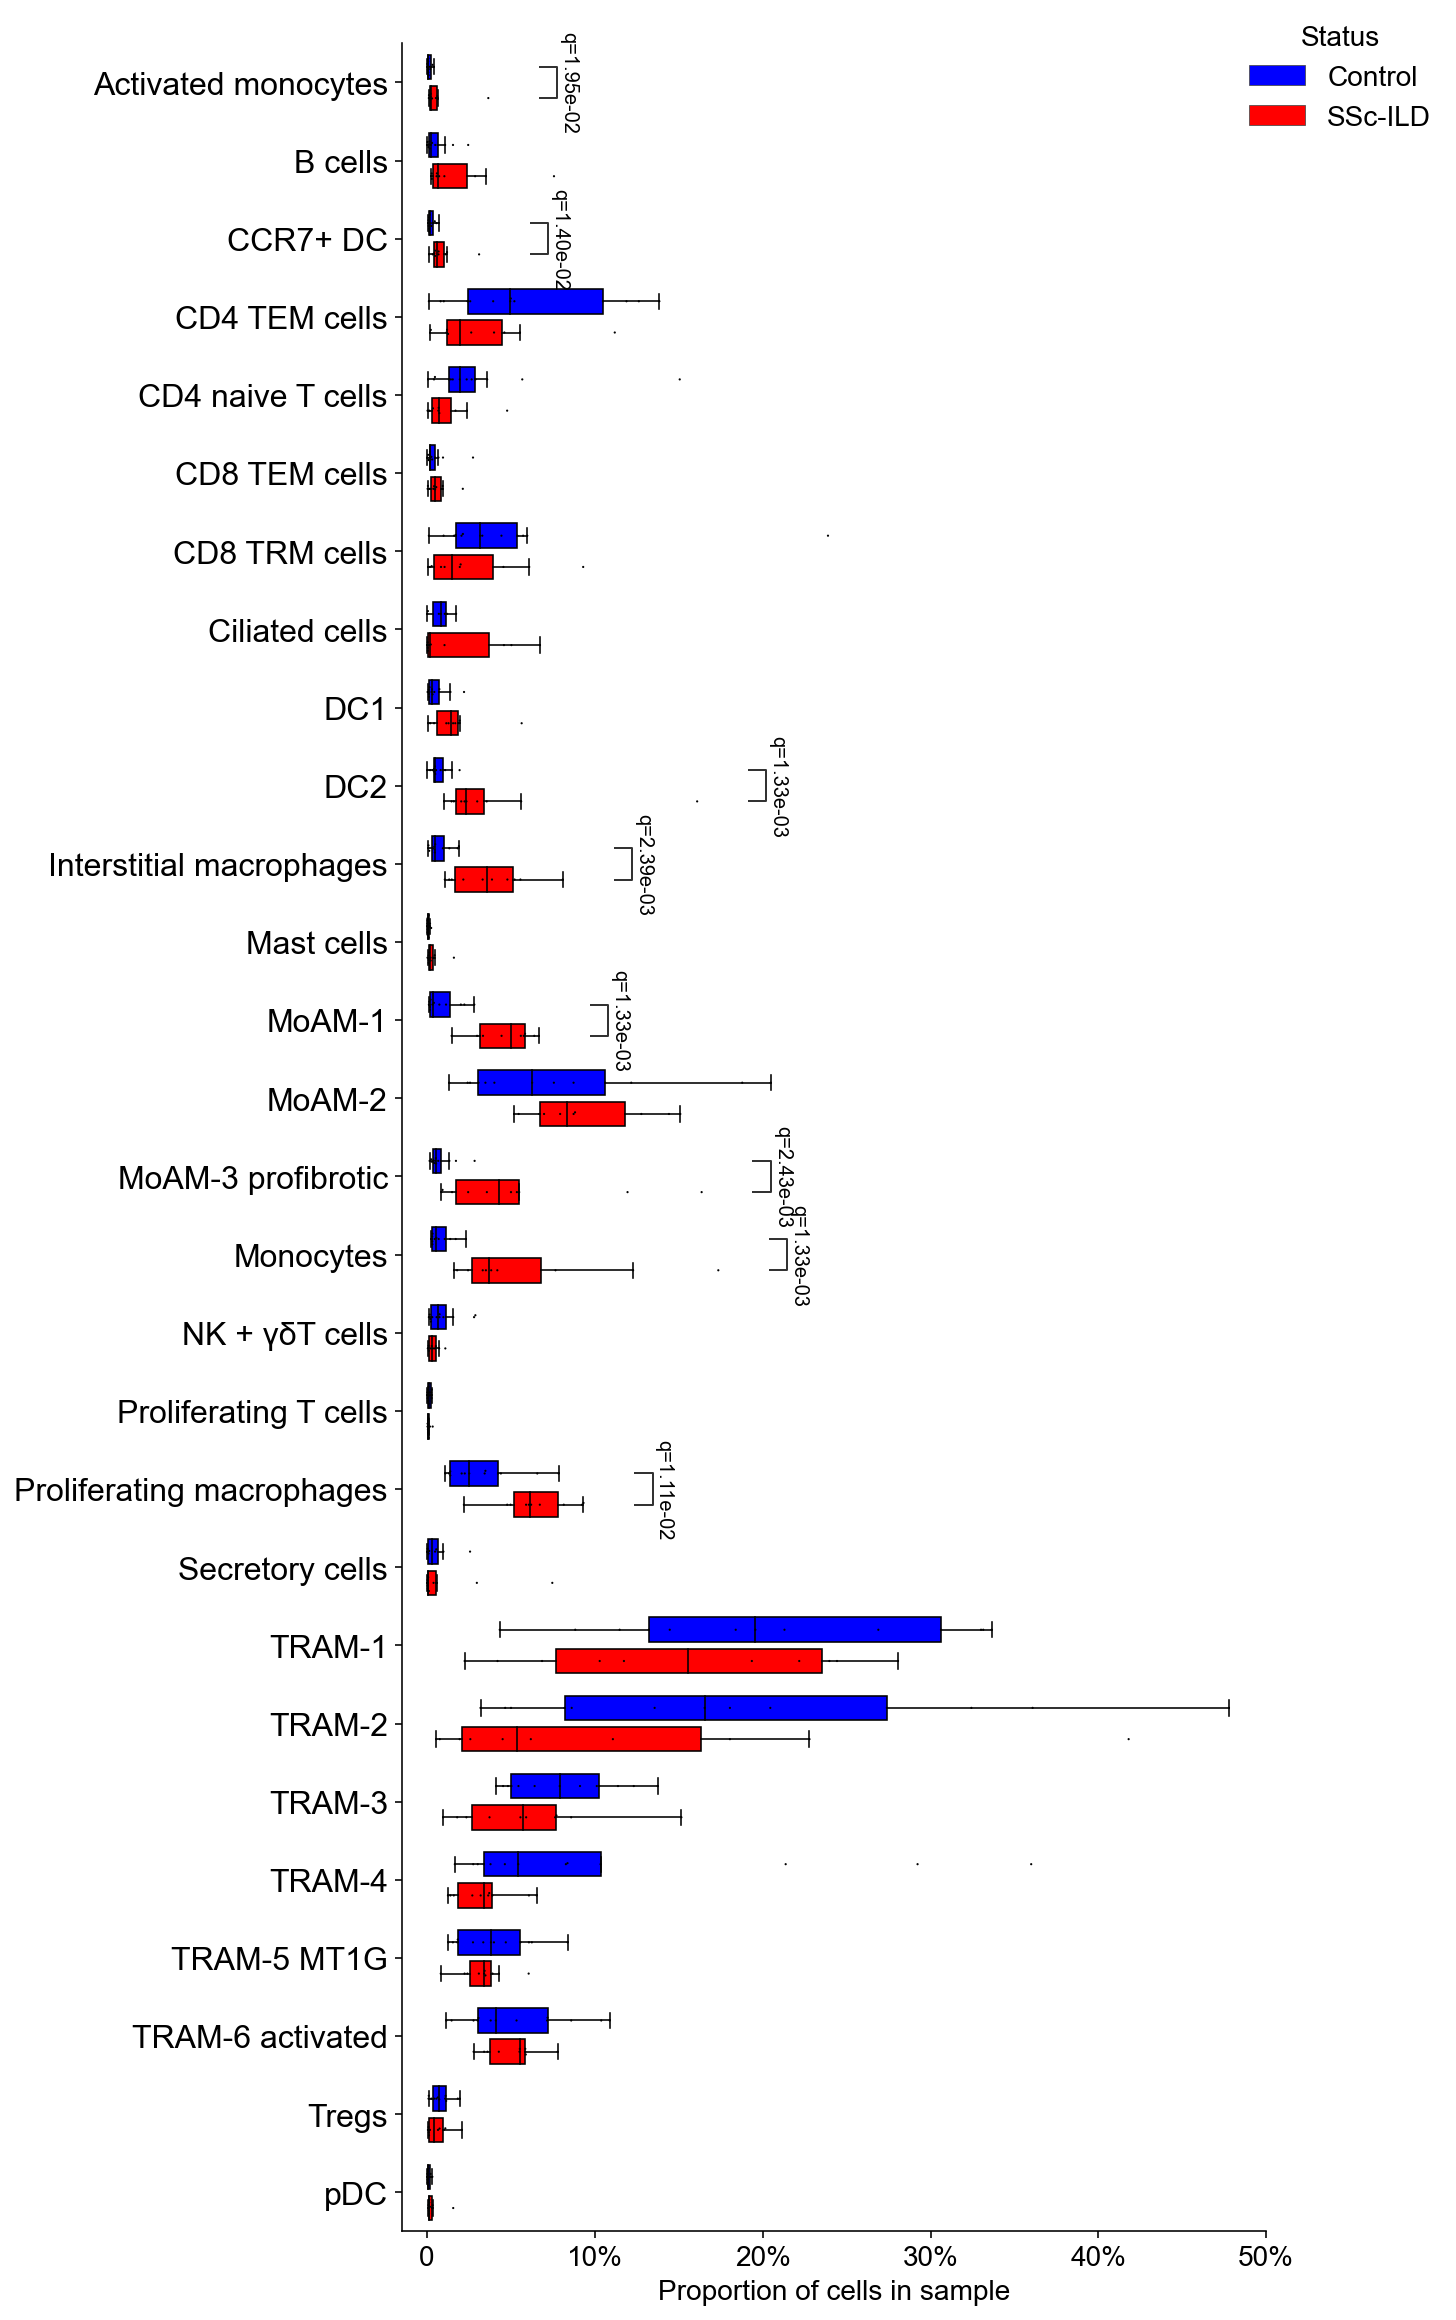

In [27]:
hue_order = ["Control", "SSc-ILD"]
fig, ax = plt.subplots(figsize=(10, 16), constrained_layout=True)
sns.boxplot(
    data=counts,
    y="cell_type",
    x="percent_in_sample",
    hue="Status",
    ax=ax,
    dodge=True,
    hue_order=hue_order,
    palette=["blue", "red"],
    saturation=1,
    linewidth=0.8,
    showfliers=False,
)
sns.swarmplot(
    data=counts,
    y="cell_type",
    x="percent_in_sample",
    hue="Status",
    ax=ax,
    color="black",
    palette=["black"]*2,
    dodge=True,
    hue_order=hue_order,
    size=1.1
)
ax.set_xlim(-1.5, 50)
ax.set_xlabel("Proportion of cells in sample", fontsize=14)
ax.set_ylabel("")
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_xticklabels(["0", "10%", "20%", "30%", "40%", "50%"])
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=16)
# ax.av
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
adjust_box_heights(fig, 0.8)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:2],
    labels[:2],
    title="Status",
    frameon=False,
    fontsize=14,
    title_fontsize=14,
    loc="upper right",
    bbox_to_anchor=(1.22, 1.02)
)

annotator = statannotations.Annotator.Annotator(
    ax,
    pairs,
    data=counts,
    x="percent_in_sample",
    y="cell_type",
    hue="Status",
    verbose=False,
    orient='h'
)

annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();

## 1.1 Clean up and reorder

We don't care about certain cell types, because we didn't sample them systematically. So remove and reorder

In [28]:
to_remove = [
    'Ciliated cells', 'Mast cells', 'Secretory cells',
    'Proliferating T cells'
]

In [ ]:
order = [
    'Monocytes',
    'Activated monocytes',
    'MoAM-1',
    'MoAM-2',
    'MoAM-3 profibrotic',

    'TRAM-1',
    'TRAM-2',
    'TRAM-3',
    'TRAM-4',
    'TRAM-5 MT1G',
    'TRAM-6 activated',

    'Interstitial macrophages',
    'Proliferating macrophages',

    'CD4 TEM cells',
    'CD4 naive T cells',
    'Tregs',
    'CD8 TEM cells',
    'CD8 TRM cells',
    'NK + γδT cells',

    'DC1',
    'DC2',
    'CCR7+ DC',
    'pDC',
    'B cells',
]

In [30]:
counts = counts.loc[~counts.cell_type.isin(to_remove)].copy()

In [31]:
counts.cell_type = pd.Categorical(counts.cell_type, categories=order)

In [32]:
stat_results = []
for ct in counts.cell_type.unique():
    ctrl = counts.percent_in_sample[counts.cell_type.eq(ct) & counts.Status.eq("Control")]
    ssc = counts.percent_in_sample[counts.cell_type.eq(ct) & counts.Status.eq("SSc-ILD")]
    if ctrl.size == 0 or ssc.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(ctrl, ssc).pvalue
    stat_results.append(["cell_type", ct, "Control", "SSc-ILD", ctrl.size, ssc.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])

In [33]:
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [34]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [35]:
pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "cell_type":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))

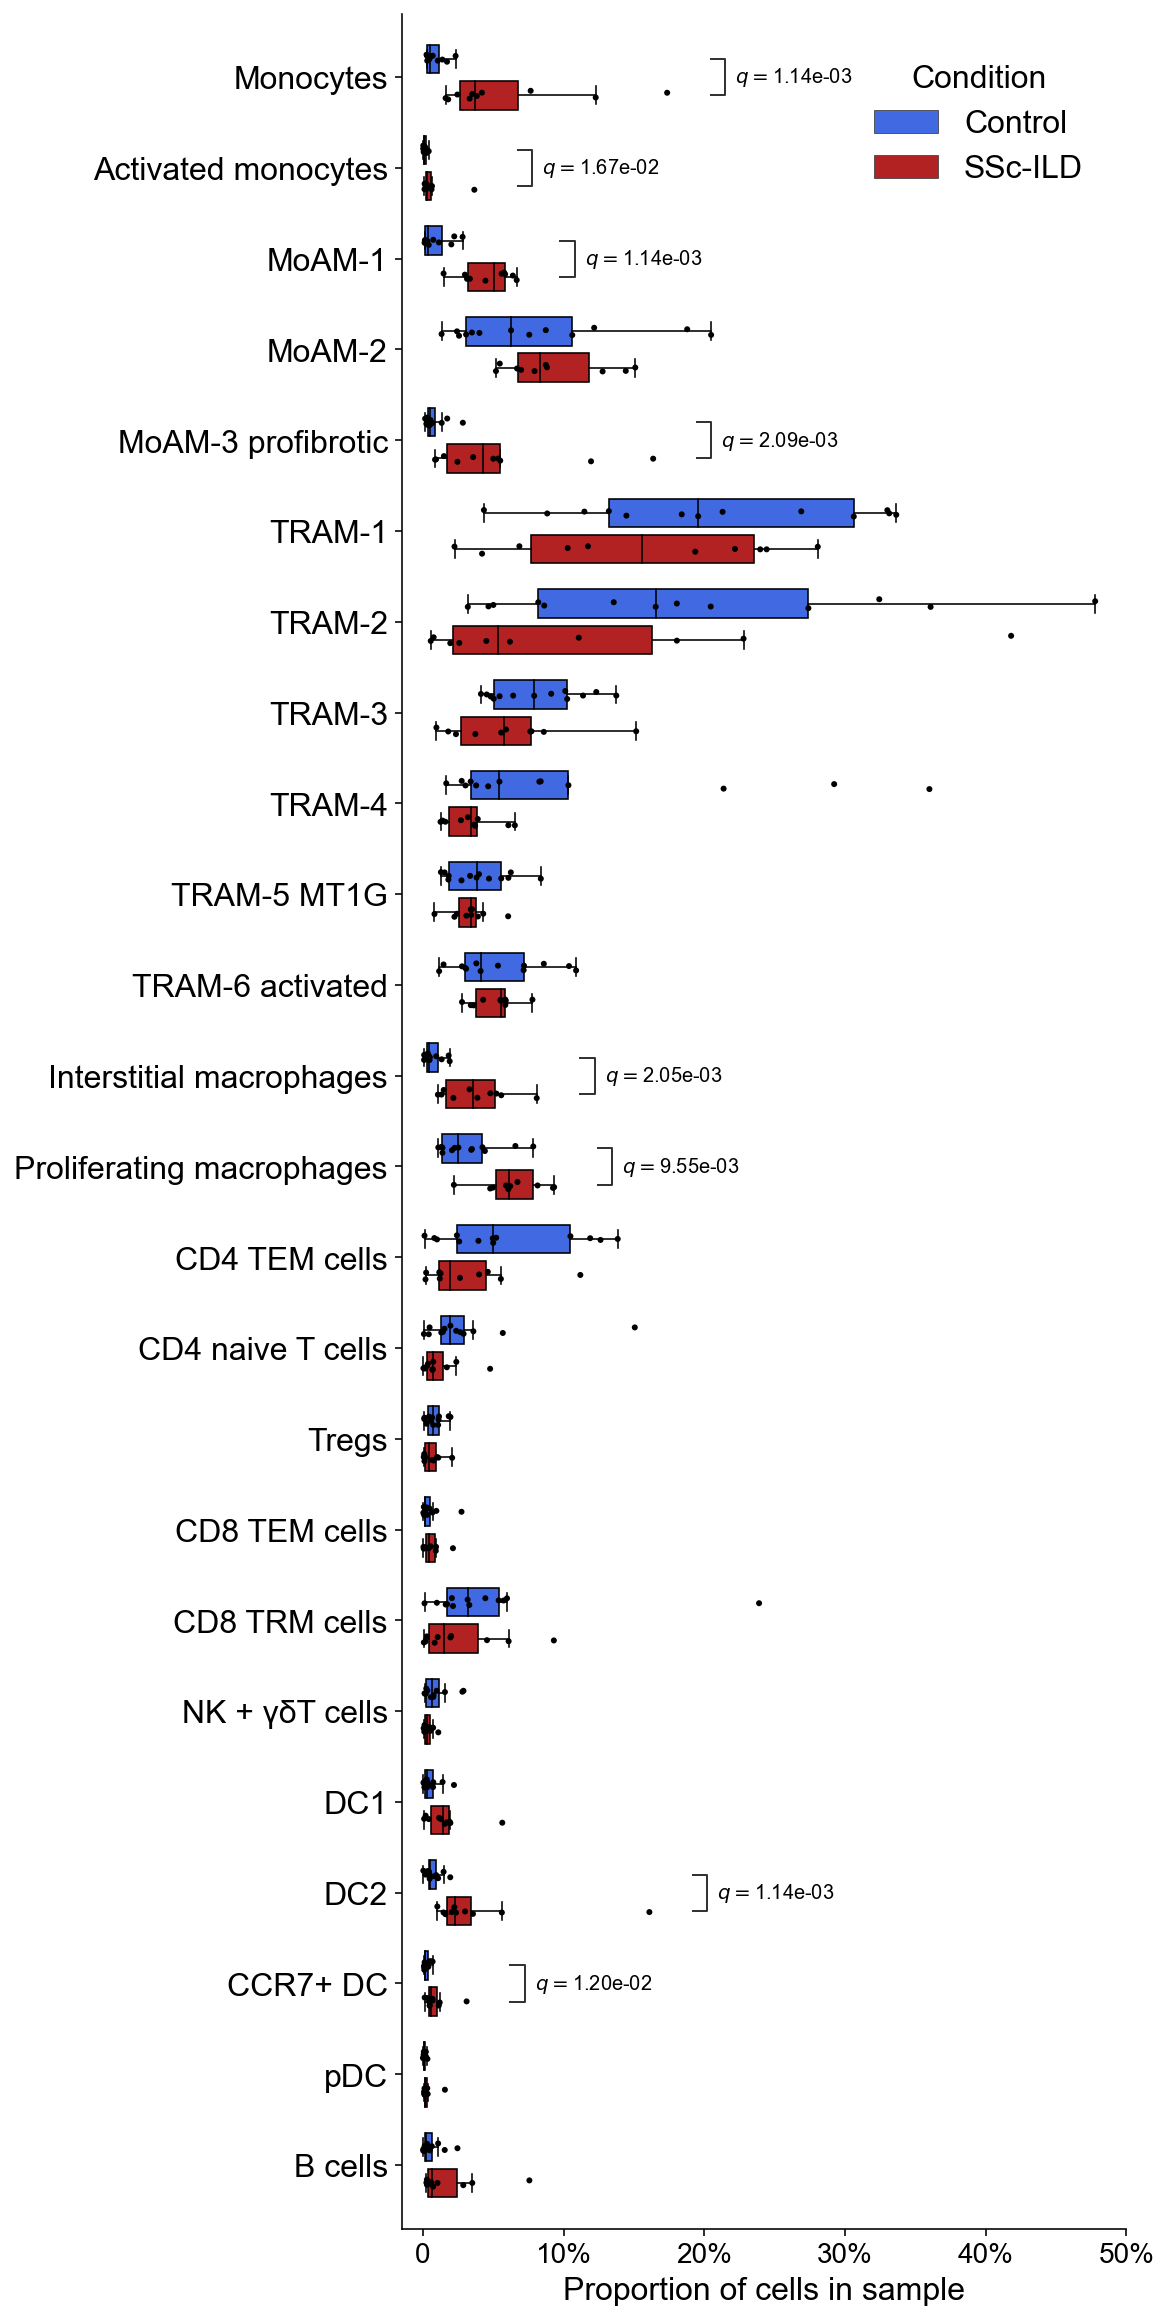

In [36]:
hue_order = ["Control", "SSc-ILD"]
fig, ax = plt.subplots(figsize=(8, 16), constrained_layout=True)
sns.boxplot(
    data=counts,
    y="cell_type",
    x="percent_in_sample",
    hue="Status",
    ax=ax,
    dodge=True,
    hue_order=hue_order,
    palette=['royalblue', 'firebrick'],
    saturation=1,
    linewidth=0.8,
    showfliers=False,
)
sns.stripplot(
    data=counts,
    y="cell_type",
    x="percent_in_sample",
    hue="Status",
    ax=ax,
    color="black",
    palette=["black"]*2,
    dodge=True,
    hue_order=hue_order,
    size=3
)
ax.set_xlim(-1.5, 50)
ax.set_xlabel("Proportion of cells in sample", fontsize=16)
ax.set_ylabel("")
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_xticklabels(["0", "10%", "20%", "30%", "40%", "50%"])
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=16)
# ax.av
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
adjust_box_heights(fig, 0.8)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:2],
    labels[:2],
    title="Condition",
    frameon=False,
    fontsize=16,
    title_fontsize=16,
    loc="upper right",
    bbox_to_anchor=(0.98, 0.99)
)

annotator = statannotations.Annotator.Annotator(
    ax,
    pairs,
    data=counts,
    x="percent_in_sample",
    y="cell_type",
    hue="Status",
    verbose=False,
    orient='h'
)

annotator._verbose = False
annotator.configure(line_width=1, text_offset=5)
annotator.set_custom_annotations([f"$q=${x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();

# make annotations horizontal
for t in ax.texts:
    t.set_rotation(0)
    t.set_va('center')
    t.set_ha('left')

fig.savefig('00_figures/Figure_2D_diff_abundance.pdf')

## For ATS 2025 abstract

In [ ]:
counts_subset = counts.loc[counts.cell_type.isin([
    'Monocytes',
    'MoAM-1',
    'MoAM-2',
    'MoAM-3 profibrotic',
    'Interstitial macrophages',
    'TRAM-1',
    'TRAM-2',
    'TRAM-3',
    'TRAM-4',
    'TRAM-5 MT1G',
    'TRAM-6 activated',
    'Proliferating macrophages',
])].copy()
counts_subset.cell_type = counts_subset.cell_type.cat.remove_unused_categories()

In [38]:
pairs_subset = [
    pair
    for pair in pairs
    if pair[0][0] in counts_subset.cell_type.cat.categories
]

In [39]:
stat_results_sign_subset = stat_results_sign.loc[
    stat_results_sign.value.isin(
        counts_subset.cell_type.cat.categories
    )
]

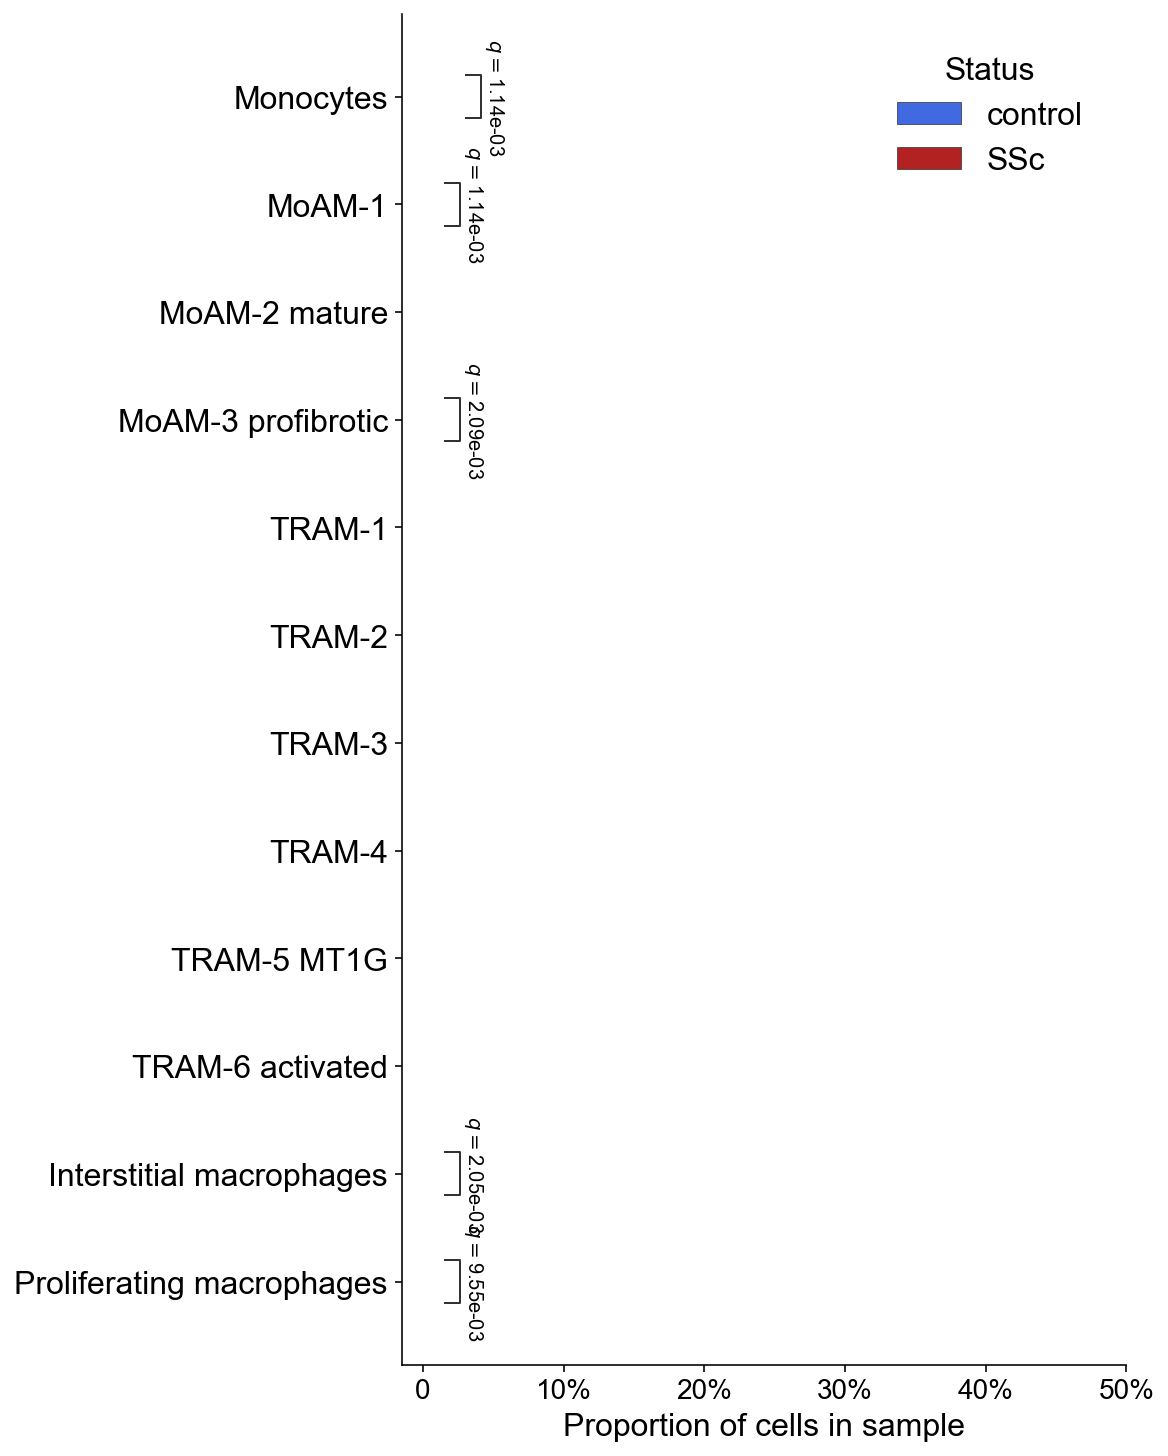

In [40]:
hue_order = ["control", "SSc"]
fig, ax = plt.subplots(figsize=(8, 10), constrained_layout=True)
sns.boxplot(
    data=counts_subset,
    y="cell_type",
    x="percent_in_sample",
    hue="Status",
    ax=ax,
    dodge=True,
    hue_order=hue_order,
    palette=['royalblue', 'firebrick'],
    saturation=1,
    linewidth=0.8,
    showfliers=False,
)
sns.stripplot(
    data=counts_subset,
    y="cell_type",
    x="percent_in_sample",
    hue="Status",
    ax=ax,
    color="black",
    palette=["black"]*2,
    dodge=True,
    hue_order=hue_order,
    size=3
)
ax.set_xlim(-1.5, 50)
ax.set_xlabel("Proportion of cells in sample", fontsize=16)
ax.set_ylabel("")
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_xticklabels(["0", "10%", "20%", "30%", "40%", "50%"])
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=16)
# ax.av
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
adjust_box_heights(fig, 0.8)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:2],
    labels[:2],
    title="Status",
    frameon=False,
    fontsize=16,
    title_fontsize=16,
    loc="upper right",
    bbox_to_anchor=(0.98, 0.99)
)

annotator = statannotations.Annotator.Annotator(
    ax,
    pairs_subset,
    data=counts_subset,
    x="percent_in_sample",
    y="cell_type",
    hue="Status",
    verbose=False,
    orient='h'
)

annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"$q=${x:.2e}" for x in stat_results_sign_subset.pval_adj])
annotator.annotate();
fig.savefig('00_figures/Figure_2C_diff_abundance_ats.pdf')

### Save to morpheus

In [37]:
counts_morph = pd.pivot_table(
    counts,
    index='cell_type',
    columns=['External Sample ID'],
    values=['percent_in_sample']
).fillna(0)

In [38]:
counts_morph.columns = counts_morph.columns.droplevel(0)

In [39]:
counts_morph.index = counts_morph.index.set_names([None])

In [40]:
GENERATOR = 'Nick'

In [41]:
CTA_DIR = pathlib.Path('04_cta')

In [42]:
os.makedirs(CTA_DIR, exist_ok=True)

In [43]:
counts_morph.to_csv(CTA_DIR / 'cta.tsv', sep='\t')

In [27]:
clinical_data = pd.read_csv('../00clinical-v2.csv')

In [29]:
samples = pd.read_csv("../00all-samples.csv")

In [32]:
clinical_data = clinical_data.merge(
    samples,
    left_on='study_code',
    right_on='Sample',
    how='left'
)

In [33]:
clinical_data['mmf'] = clinical_data.patient_on_mmf.map(
    {True: 'MMF', False: 'Naive'}
)

In [34]:
# Copy value for SSc8 from SSc6 (repeat sample)
clinical_data.loc[clinical_data['External Sample ID'].eq('SSc_SSc8'), 'mmf'] = 'Naive'

In [52]:
clinical_data.to_csv(CTA_DIR / 'meta.tsv', sep='\t')

In [53]:
HTML = """
<!DOCTYPE html>
<html>
<head>
    <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
    <meta http-equiv="content-type" content="text/html; charset=utf8"/>
    <title>Pathogen comparisons GSEA</title>
    <style type="text/css">
        html {
          margin: 0; padding: 0;
          font-size: 20px; font-family: Helvetica, Verdana, sans-serif;
        }
        body {margin: 0; padding: 10px 10px;}
        a {color: #1385cb}
        a:visited {color: #0e74bc}
        .header {margin-bottom: 10px;}
        .header h2, .header h3 {font-weight: normal; text-align: center; margin: 0 0 6px 0;}
        #morpheus-container {
            width: auto;
            height: auto;
            min-width: 1200px;
            min-height: 800px;
            visibility: hidden;
        }
      </style>
    <link rel="stylesheet" href="https://software.broadinstitute.org/morpheus/css/morpheus-latest.min.css">
    <script>if (typeof module === 'object') {
    window.module = module;
    module = undefined;

    }</script>

    <script type="text/javascript" src="https://software.broadinstitute.org/morpheus/js/morpheus-external-latest.min.js"></script>
    <script src="https://software.broadinstitute.org/morpheus/js/morpheus-latest.min.js"></script>
</head>
<body>
    <div class="header">
        <h2>Cell type abundance, epithelial cells excluded</h2>
        Generated by %s on %s
    </div>
    <div id="morpheus-container"></div>

    <script type="text/javascript">
        window.heatmap = new morpheus.HeatMap({
            el: document.querySelector('#morpheus-container'),
            name: "Cell type abundance",
            dataset: "cta.tsv",
            rows: [
                {field: "id", display: ["text"]}
            ],
            columns: [
                {field: "id", display: ["color"]},
                {field: "Sample", display: ["color"]},
                {field: "Sex", display: ["color"]},
                {field: "Study", display: ["color"]},
                {field: "Chemistry", display: ["color"]},
                {field: "Status", display: ["color"]},
                {field: "fvc_pred", display: ["color"]},
                {field: "mmf", display: ["color"]}
            ],
            columnAnnotations: [{
                file: "meta.tsv",
                datasetField: "id",
                fileField: "External Sample ID"
            }],
            columnColorModel: {
                "Status": {
                    "control": "#6599f2",
                    "SSc": "#d34006"
                },
                "Chemistry": {
                    "10x 3' V2": "#56407f",
                    "10x 3' V3": "#ed6146"
                },
                "mmf": {
                    "Naive": "#227f69",
                    "MMF": "#b54519"
                }
            },
            rowColorModel: {
            },
            colorScheme: { // optional color scheme. default is relative
                scalingMode: 'relative',
                map: [{
                    value: 1,
                    color: '#ff0000'
                }, {
                    value: 0,
                    color: '#0000ff'
                }]
            },
            tools: [{ name: "Hierarchical Clustering", params: {cluster: "Rows and columns"} }]
        });
        window.onload = function() {
            window.setTimeout(function() {
                window.heatmap.fitToWindow({fitRows: true, fitColumns: true, repaint: true});
                window.heatmap.fitToWindow({fitRows: true, fitColumns: true, repaint: true});
                document.getElementById('morpheus-container').style.visibility = 'visible';
            }, 200)
        }
    </script>
</body>
</html>
"""


In [54]:
html = HTML % (
    GENERATOR,
    datetime.datetime.now().strftime('%d %b %Y, %I:%M%p')
)

In [55]:
with open(CTA_DIR / 'index.html', 'w') as out:
    out.write(html)

### Now plot this too

In [56]:
counts_morph = pd.pivot_table(
    counts,
    index='cell_type',
    columns=['External Sample ID'],
    values=['percent_in_sample']
).fillna(0)

In [57]:
counts_morph.columns = counts_morph.columns.droplevel(0)

In [58]:
counts_morph.index = counts_morph.index.set_names([None])

In [59]:
counts_morph[:] = sklearn.preprocessing.StandardScaler().fit_transform((counts_morph ** 0.5).T).T

In [60]:
clinical_data = clinical_data.set_index('External Sample ID')

In [61]:
clinical_data.fvc_pred

External Sample ID
SSc_C1              NaN
SSc_C2              NaN
SSc_SSc6      80.987043
SSc_SSc8      80.987043
SSc_SSc9      49.922879
SSc_SSc10     70.047361
SSc_SSc7      80.562132
SSc_SSc12     72.850001
SSc_SSc4      74.406565
SSc_SSc13     54.696651
SSc_SSc14     66.953562
SSc_C3              NaN
SSc_C5              NaN
SSc_C11             NaN
SSc_SSc15     65.901154
Duke_C1      110.130689
Duke_C2      111.132097
Duke_C3      110.257333
Duke_C4       93.744917
Duke_C5       99.535300
Duke_C6      109.547334
Duke_C7      106.506408
Duke_C8      100.355287
Name: fvc_pred, dtype: float64

In [62]:
# FVC_panel = mpl.colors.LinearSegmentedColormap.from_list('Q', ['#d1b410', '#123a1a', '#33d110'])
FVC_panel = mpl.colors.LinearSegmentedColormap.from_list('Q', ['#333333', '#eeeeee'])
clinical_data_colors = clinical_data.copy()
idx = clinical_data_colors.fvc_pred.isna()
clinical_data_colors.fvc_pred[idx] = clinical_data_colors.fvc_pred.min()
clinical_data_colors.mmf[clinical_data_colors.mmf.isna()] = 'Naive'
clinical_data_colors.mmf = pd.Categorical(clinical_data_colors.mmf, categories=['Naive', 'MMF'])
col_colors = get_color_annotations(clinical_data_colors, {
    'Status': ['royalblue', 'firebrick'],
    # 'fvc_pred': 'Greys_r', #sns.dark_palette("#b544dd", as_cmap=True),
    'fvc_pred': FVC_panel,
    'mmf': ['white', '#0f5356']
})
col_colors.fvc_pred[idx] = 'white'

<ipython-input-62-cb5c33720a18>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_data_colors.fvc_pred[idx] = clinical_data_colors.fvc_pred.min()
<ipython-input-62-cb5c33720a18>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_data_colors.mmf[clinical_data_colors.mmf.isna()] = 'Naive'
<ipython-input-62-cb5c33720a18>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_colors.fvc_pred[idx] = 'white'


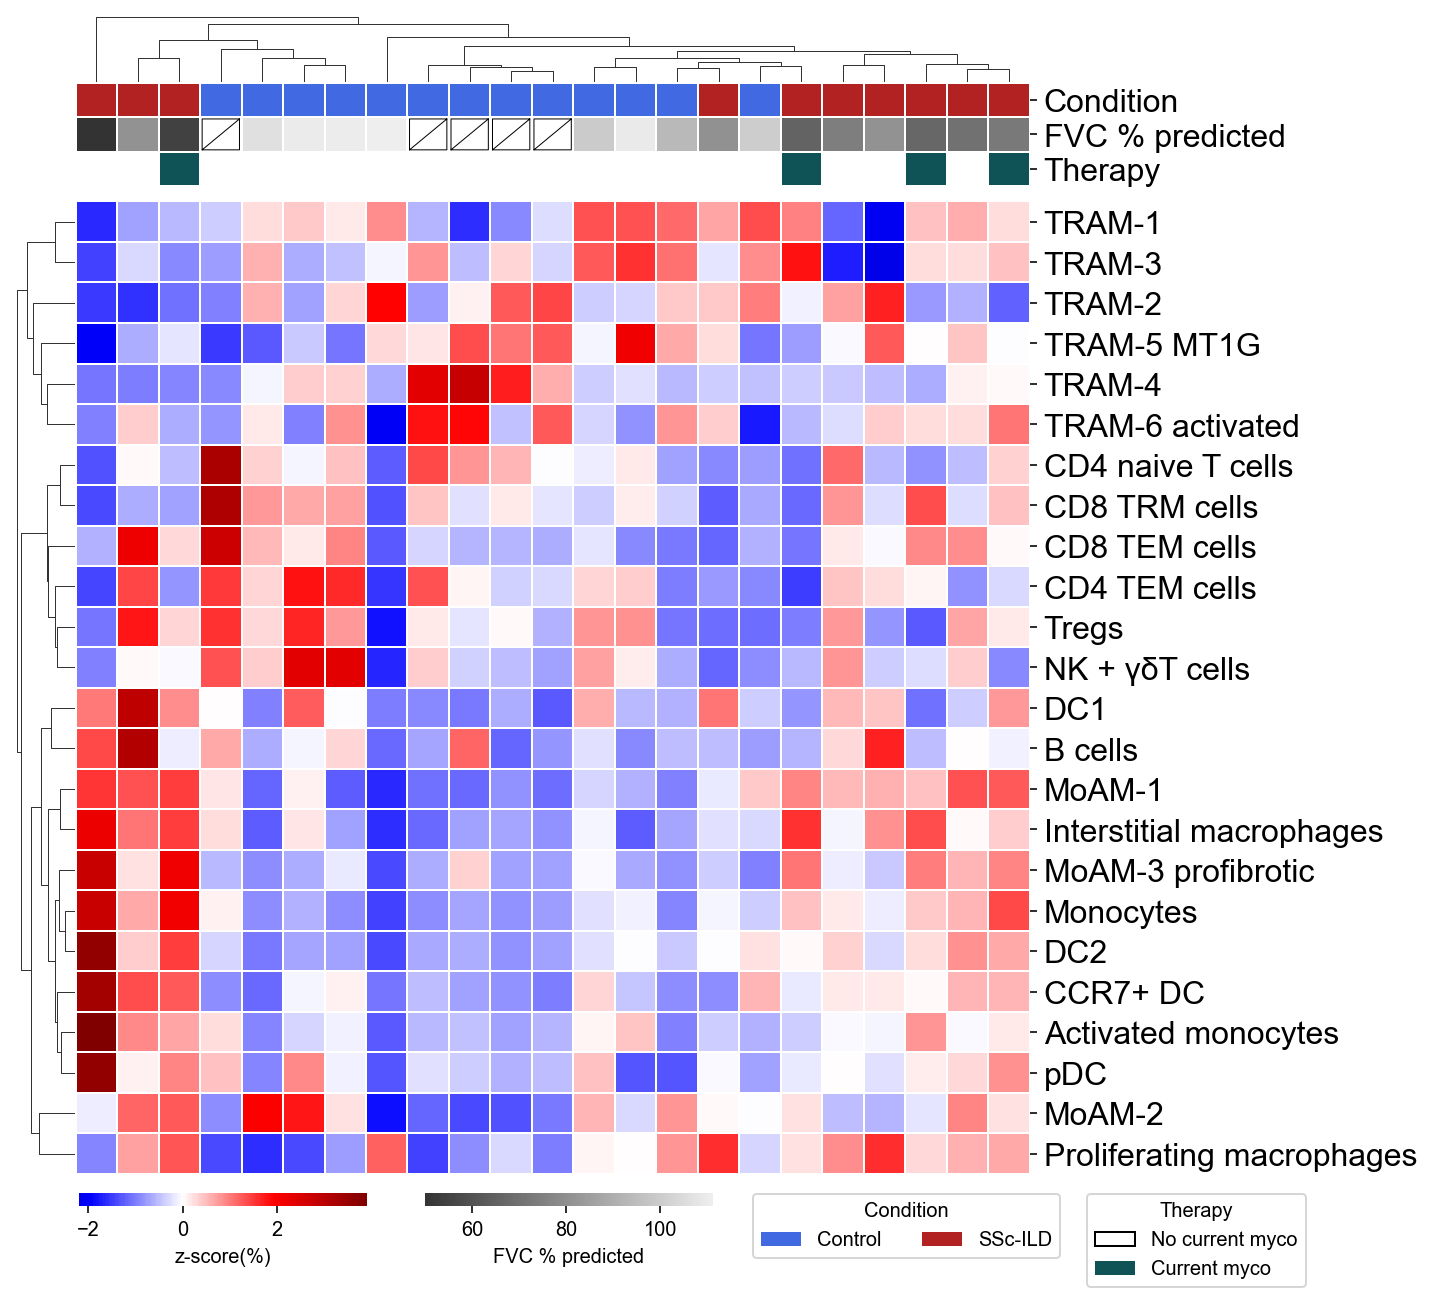

In [ ]:
clustermap = sns.clustermap(
    counts_morph,
    # z_score=1,
    method='complete',
    metric='cityblock',
    cmap='seismic',
    figsize=(10, 9),
    colors_ratio=0.03,
    dendrogram_ratio=0.06,
    center=0,
    # yticklabels=col_names,
    xticklabels=[],
    col_colors=col_colors,
    cbar_pos=(0.065, 0.02, 0.2, 0.01),
    cbar_kws=dict(
        label='z-score(%)',
        orientation='horizontal',
        ticks=[-2, 0, 2, 4, 6]
    ),
    linewidths=0.5
)

clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_ymajorticklabels(), fontsize=16)
clustermap.ax_heatmap.set_xlabel('')

clustermap.ax_col_colors.set_yticklabels(['Condition', 'FVC % predicted', 'Therapy'], fontsize=16)

FVC_IDX = 1.5
INNER_R = 0.05
OFFS = 0.5 - INNER_R
for i in pd.Series(
    range(counts_morph.shape[1]),
    index=counts_morph.columns[clustermap.dendrogram_col.reordered_ind]
)[idx].values:
    i += 0.5
    clustermap.ax_col_colors.add_artist(mpl.lines.Line2D(
        [i - OFFS, i - OFFS, i + OFFS, i + OFFS, i - OFFS, i + OFFS],
        [FVC_IDX + OFFS, FVC_IDX - OFFS, FVC_IDX - OFFS, FVC_IDX + OFFS, FVC_IDX + OFFS, FVC_IDX - OFFS],
        lw=0.5,
        c='k'
    ))

fvc_leg_ax = clustermap.figure.add_axes((0.3, 0.075, 0.2, 0.01))
fvc_cbar = clustermap.figure.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(
            vmin=clinical_data_colors.fvc_pred.min(),
            vmax=clinical_data_colors.fvc_pred.max()
        ),
        cmap=FVC_panel
    ),
    cax=fvc_leg_ax,
    label='FVC % predicted',
    orientation='horizontal',
    drawedges=False
)

fvc_cbar.outline.set_linewidth(0)

l1 = clustermap.ax_heatmap.legend(
    handles=[
        mpl.patches.Patch(fc='royalblue', label='Control'),
        mpl.patches.Patch(fc='firebrick', label='SSc-ILD'),
    ],
    loc='upper left',
    bbox_to_anchor=(0.7, -0.01),
    title='Condition',
    ncol=2
)

clustermap.ax_heatmap.legend(
    handles=[
        mpl.patches.Patch(fc='white', label='No current myco', ec='k'),
        mpl.patches.Patch(fc='#0f5356', label='Current myco'),
    ],
    loc='upper left',
    bbox_to_anchor=(1.05, -0.01),
    title='Therapy',
    ncol=1
)

clustermap.ax_heatmap.add_artist(l1)

clustermap.fig.subplots_adjust(right=0.72, bottom=0.1)

p = clustermap.ax_col_colors.get_position()
h = p.y1 - p.y0
p_hm = clustermap.ax_heatmap.get_position()
p.y0 = p_hm.y1 + 0.012
p.y1 = p.y0 + h
clustermap.ax_col_colors.set_position(p)
p = clustermap.ax_col_dendrogram.get_position()
p.y0 += 0.012
p.y1 += 0.012
clustermap.ax_col_dendrogram.set_position(p)

clustermap.cax.set_position((0.06, 0.075, 0.2, 0.01))

clustermap.fig.savefig('00_figures/Figure_2E_abundance_clust.pdf')

## 1.2 Diff abundance for MMF

In [35]:
clinical = pd.read_csv("../00clinical-v2.csv")

In [36]:
samples = pd.read_csv("../00all-samples.csv")

In [37]:
on_mmf = clinical[['study_code', 'patient_on_mmf']].copy()

In [38]:
on_mmf = on_mmf.dropna()

In [41]:
on_mmf = on_mmf.merge(
    samples[['Sample', 'External Sample ID']],
    how='left',
    left_on='study_code',
    right_on='Sample'
)

In [42]:
on_mmf.patient_on_mmf = on_mmf.patient_on_mmf.replace({True: 'MMF', False: 'Naive'})

In [32]:
counts_mmf = counts.copy().merge(on_mmf, how='right', on='External Sample ID')

In [ ]:
stat_results = []
for ct in counts_mmf.cell_type.unique():
    ctrl = counts_mmf.percent_in_sample[
        counts_mmf.cell_type.eq(ct)
        & counts_mmf.patient_on_mmf.eq('Naive')
    ]
    mmf = counts_mmf.percent_in_sample[
        counts_mmf.cell_type.eq(ct)
        & counts_mmf.patient_on_mmf.eq('MMF')
    ]
    if ctrl.size == 0 or mmf.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(ctrl, mmf).pvalue
    stat_results.append(["cell_type", ct, "Naive", "MMF", ctrl.size, mmf.size, pval])
stat_results = pd.DataFrame(stat_results, columns=["variable", "value", "group1", "group2",
                                                   "group1_size", "group2_size", "pval"])

In [74]:
stat_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stat_results.pval, alpha=0.05)[1]

In [75]:
stat_results_sign = stat_results.loc[stat_results.pval_adj < 0.05, :]

In [76]:
pairs = []
for _, r in stat_results_sign.iterrows():
    if r.variable == "cell_type":
        pairs.append(((r.value, r.group1), (r.value, r.group2)))
    else:
        pairs.append(((r.group1, r.value), (r.group2, r.value)))

In [77]:
stat_results

variable                      value group1 group2  group1_size  \
0   cell_type        Activated monocytes  Naive    MMF            6   
1   cell_type                    B cells  Naive    MMF            6   
2   cell_type                   CCR7+ DC  Naive    MMF            6   
3   cell_type              CD4 TEM cells  Naive    MMF            6   
4   cell_type          CD4 naive T cells  Naive    MMF            6   
5   cell_type              CD8 TEM cells  Naive    MMF            6   
6   cell_type              CD8 TRM cells  Naive    MMF            6   
7   cell_type                        DC1  Naive    MMF            6   
8   cell_type                        DC2  Naive    MMF            6   
9   cell_type   Interstitial macrophages  Naive    MMF            6   
10  cell_type                     MoAM-1  Naive    MMF            6   
11  cell_type                     MoAM-2  Naive    MMF            6   
12  cell_type         MoAM-3 profibrotic  Naive    MMF            6   
13  cell_type                  Monocytes  Naive    MMF            6   
14  cell_type             NK + γδT cells  Naive    MMF            6   
15  cell_type  Proliferating macrophages  Naive    MMF            6   
16  cell_type                     TRAM-1  Naive    MMF            6   
17  cell_type                     TRAM-2  Naive    MMF            6   
18  cell_type                     TRAM-3  Naive    MMF            6   
19  cell_type                     TRAM-4  Naive    MMF            6   
20  cell_type                TRAM-5 MT1G  Naive    MMF            6   
21  cell_type           TRAM-6 activated  Naive    MMF            6   
22  cell_type                      Tregs  Naive    MMF            6   
23  cell_type                        pDC  Naive    MMF            6   

    group2_size      pval  pval_adj  
0             4  0.457553  0.457553  
1             4  0.034977  0.439278  
2             4  0.297016  0.445524  
3             4  0.227773  0.445524  
4             4  0.457553  0.457553  
5             4  0.457553  0.457553  
6             4  0.297016  0.445524  
7             4  0.120477  0.445524  
8             4  0.457553  0.457553  
9             4  0.120477  0.445524  
10            4  0.457553  0.457553  
11            4  0.227773  0.445524  
12            4  0.054910  0.439278  
13            4  0.227773  0.445524  
14            4  0.374560  0.457553  
15            4  0.227773  0.445524  
16            4  0.120477  0.445524  
17            4  0.297016  0.445524  
18            4  0.054910  0.439278  
19            4  0.457553  0.457553  
20            4  0.297016  0.445524  
21            4  0.457553  0.457553  
22            4  0.227773  0.445524  
23            4  0.297016  0.445524

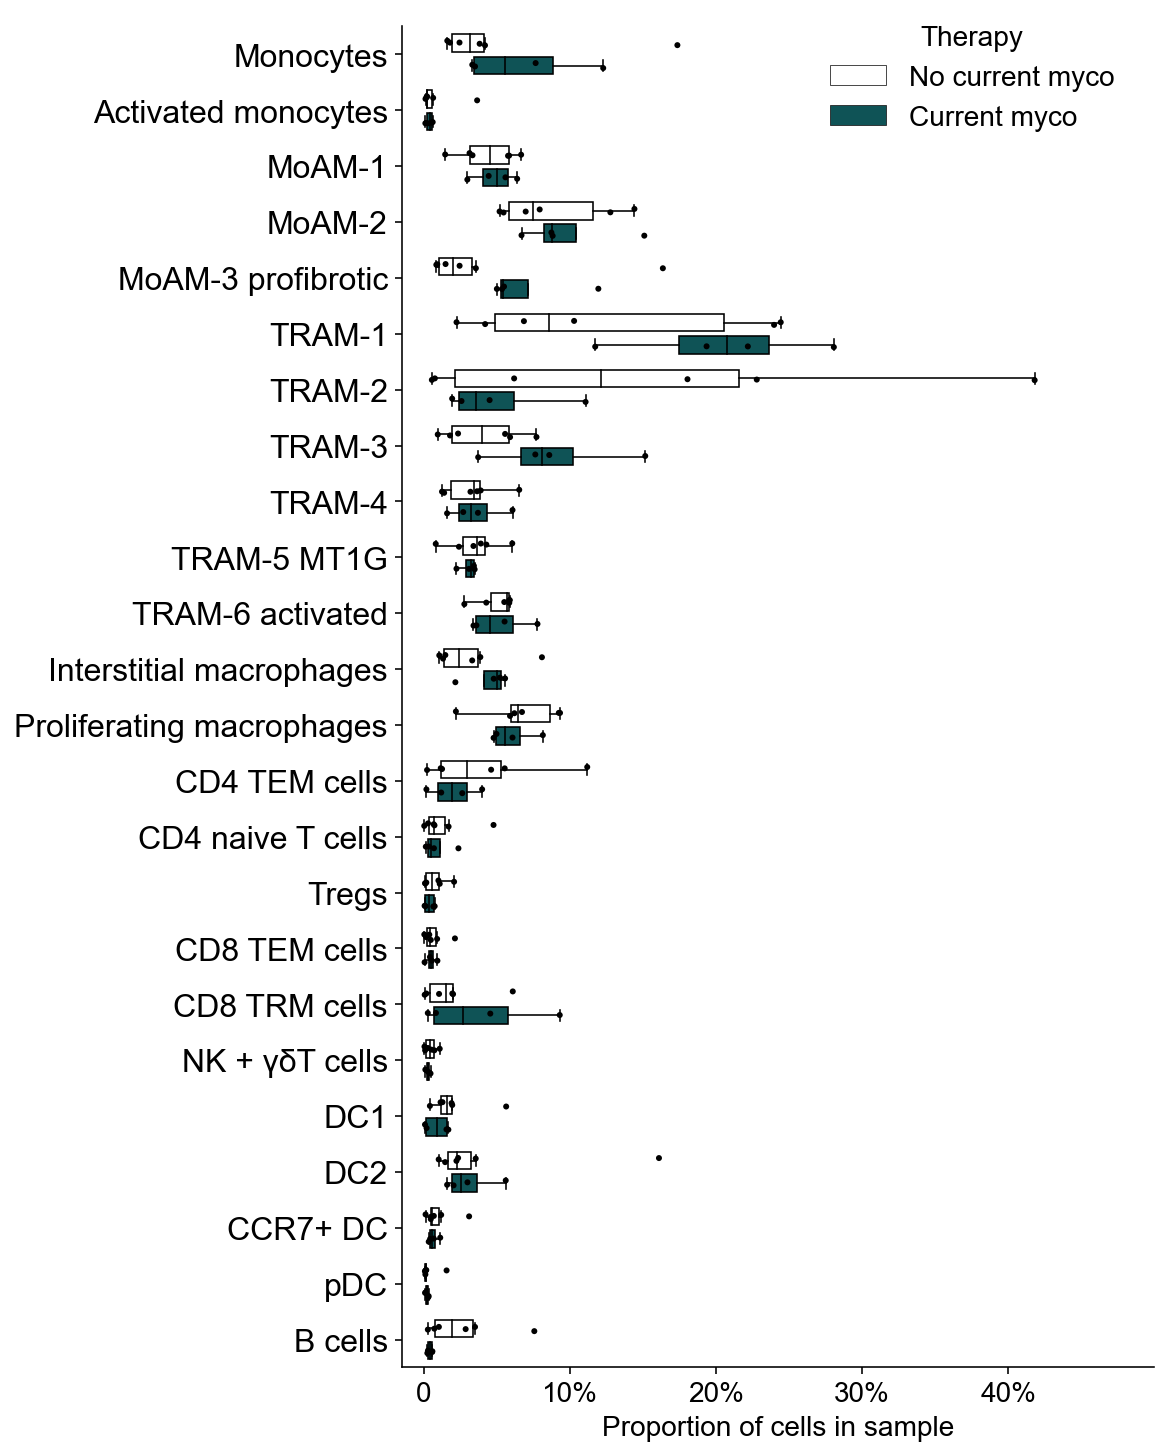

In [78]:
hue_order = ["Naive", "MMF"]
fig, ax = plt.subplots(figsize=(8, 10), constrained_layout=True)
sns.boxplot(
    data=counts_mmf,
    y="cell_type",
    x="percent_in_sample",
    hue="patient_on_mmf",
    ax=ax,
    dodge=True,
    hue_order=hue_order,
    palette=['white', '#0f5356'],
    saturation=1,
    linewidth=0.8,
    showfliers=False,
)
sns.stripplot(
    data=counts_mmf,
    y="cell_type",
    x="percent_in_sample",
    hue="patient_on_mmf",
    ax=ax,
    color="black",
    palette=["black"]*2,
    dodge=True,
    hue_order=hue_order,
    size=3
)
ax.set_xlim(-1.5, 50)
ax.set_xlabel("Proportion of cells in sample", fontsize=14)
ax.set_ylabel("")
ax.set_xticks([0, 10, 20, 30, 40])
ax.set_xticklabels(["0", "10%", "20%", "30%", "40%"])
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=16)
# ax.av
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
adjust_box_heights(fig, 0.8)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:2],
    ['No current myco', 'Current myco'],
    title="Therapy",
    frameon=False,
    fontsize=14,
    title_fontsize=14,
    loc="upper right",
    bbox_to_anchor=(0.98, 1.02)
)

fig.savefig('00_figures/Figure_S4C_diff_abd_myco.pdf')

## 2. Clinical correlation

In [20]:
cols = [
    "fvc_pred", "fev1_pred", "dlco_pred", 'k_score_ggo', 'k_score_fib'
]

Well, not only PFT now

In [21]:
pft_data = clinical.loc[:, ["study_code"] + cols]

In [38]:
cell_types = adata.obs.cell_type.cat.categories

In [39]:
clusters = (
    list(cell_types[cell_types.str.contains("MoAM")])
    + ["Interstitial macrophages", 'Proliferating macrophages', 'Monocytes']
    + list(cell_types[cell_types.str.contains("TRAM")])
)

In [40]:
df = counts.loc[counts.cell_type.isin(clusters), :].copy()

In [41]:
df.cell_type = df.cell_type.cat.remove_unused_categories()

In [42]:
sample_id_to_sample = samples.loc[:, ["External Sample ID", "Sample"]].set_index("External Sample ID").Sample

In [43]:
df["Sample"] = sample_id_to_sample[df["External Sample ID"]].values

In [44]:
df.shape

(272, 7)

In [45]:
df = df.merge(pft_data, left_on="Sample", right_on='study_code')

In [46]:
df.shape

(260, 13)

In [47]:
np.all(pft_data.study_code.isin(df['Sample']))

True

In [48]:
df = df.melt(
    id_vars=["cell_type", "percent_in_sample", 'External Sample ID', 'Status'],
    value_vars=["fvc_pred", "fev1_pred", "dlco_pred", 'k_score_ggo', 'k_score_fib'],
    var_name="pft_test",
    value_name="pft_measurement"
)

In [49]:
df = df.dropna()

## 2.1 Correlation with PFT values

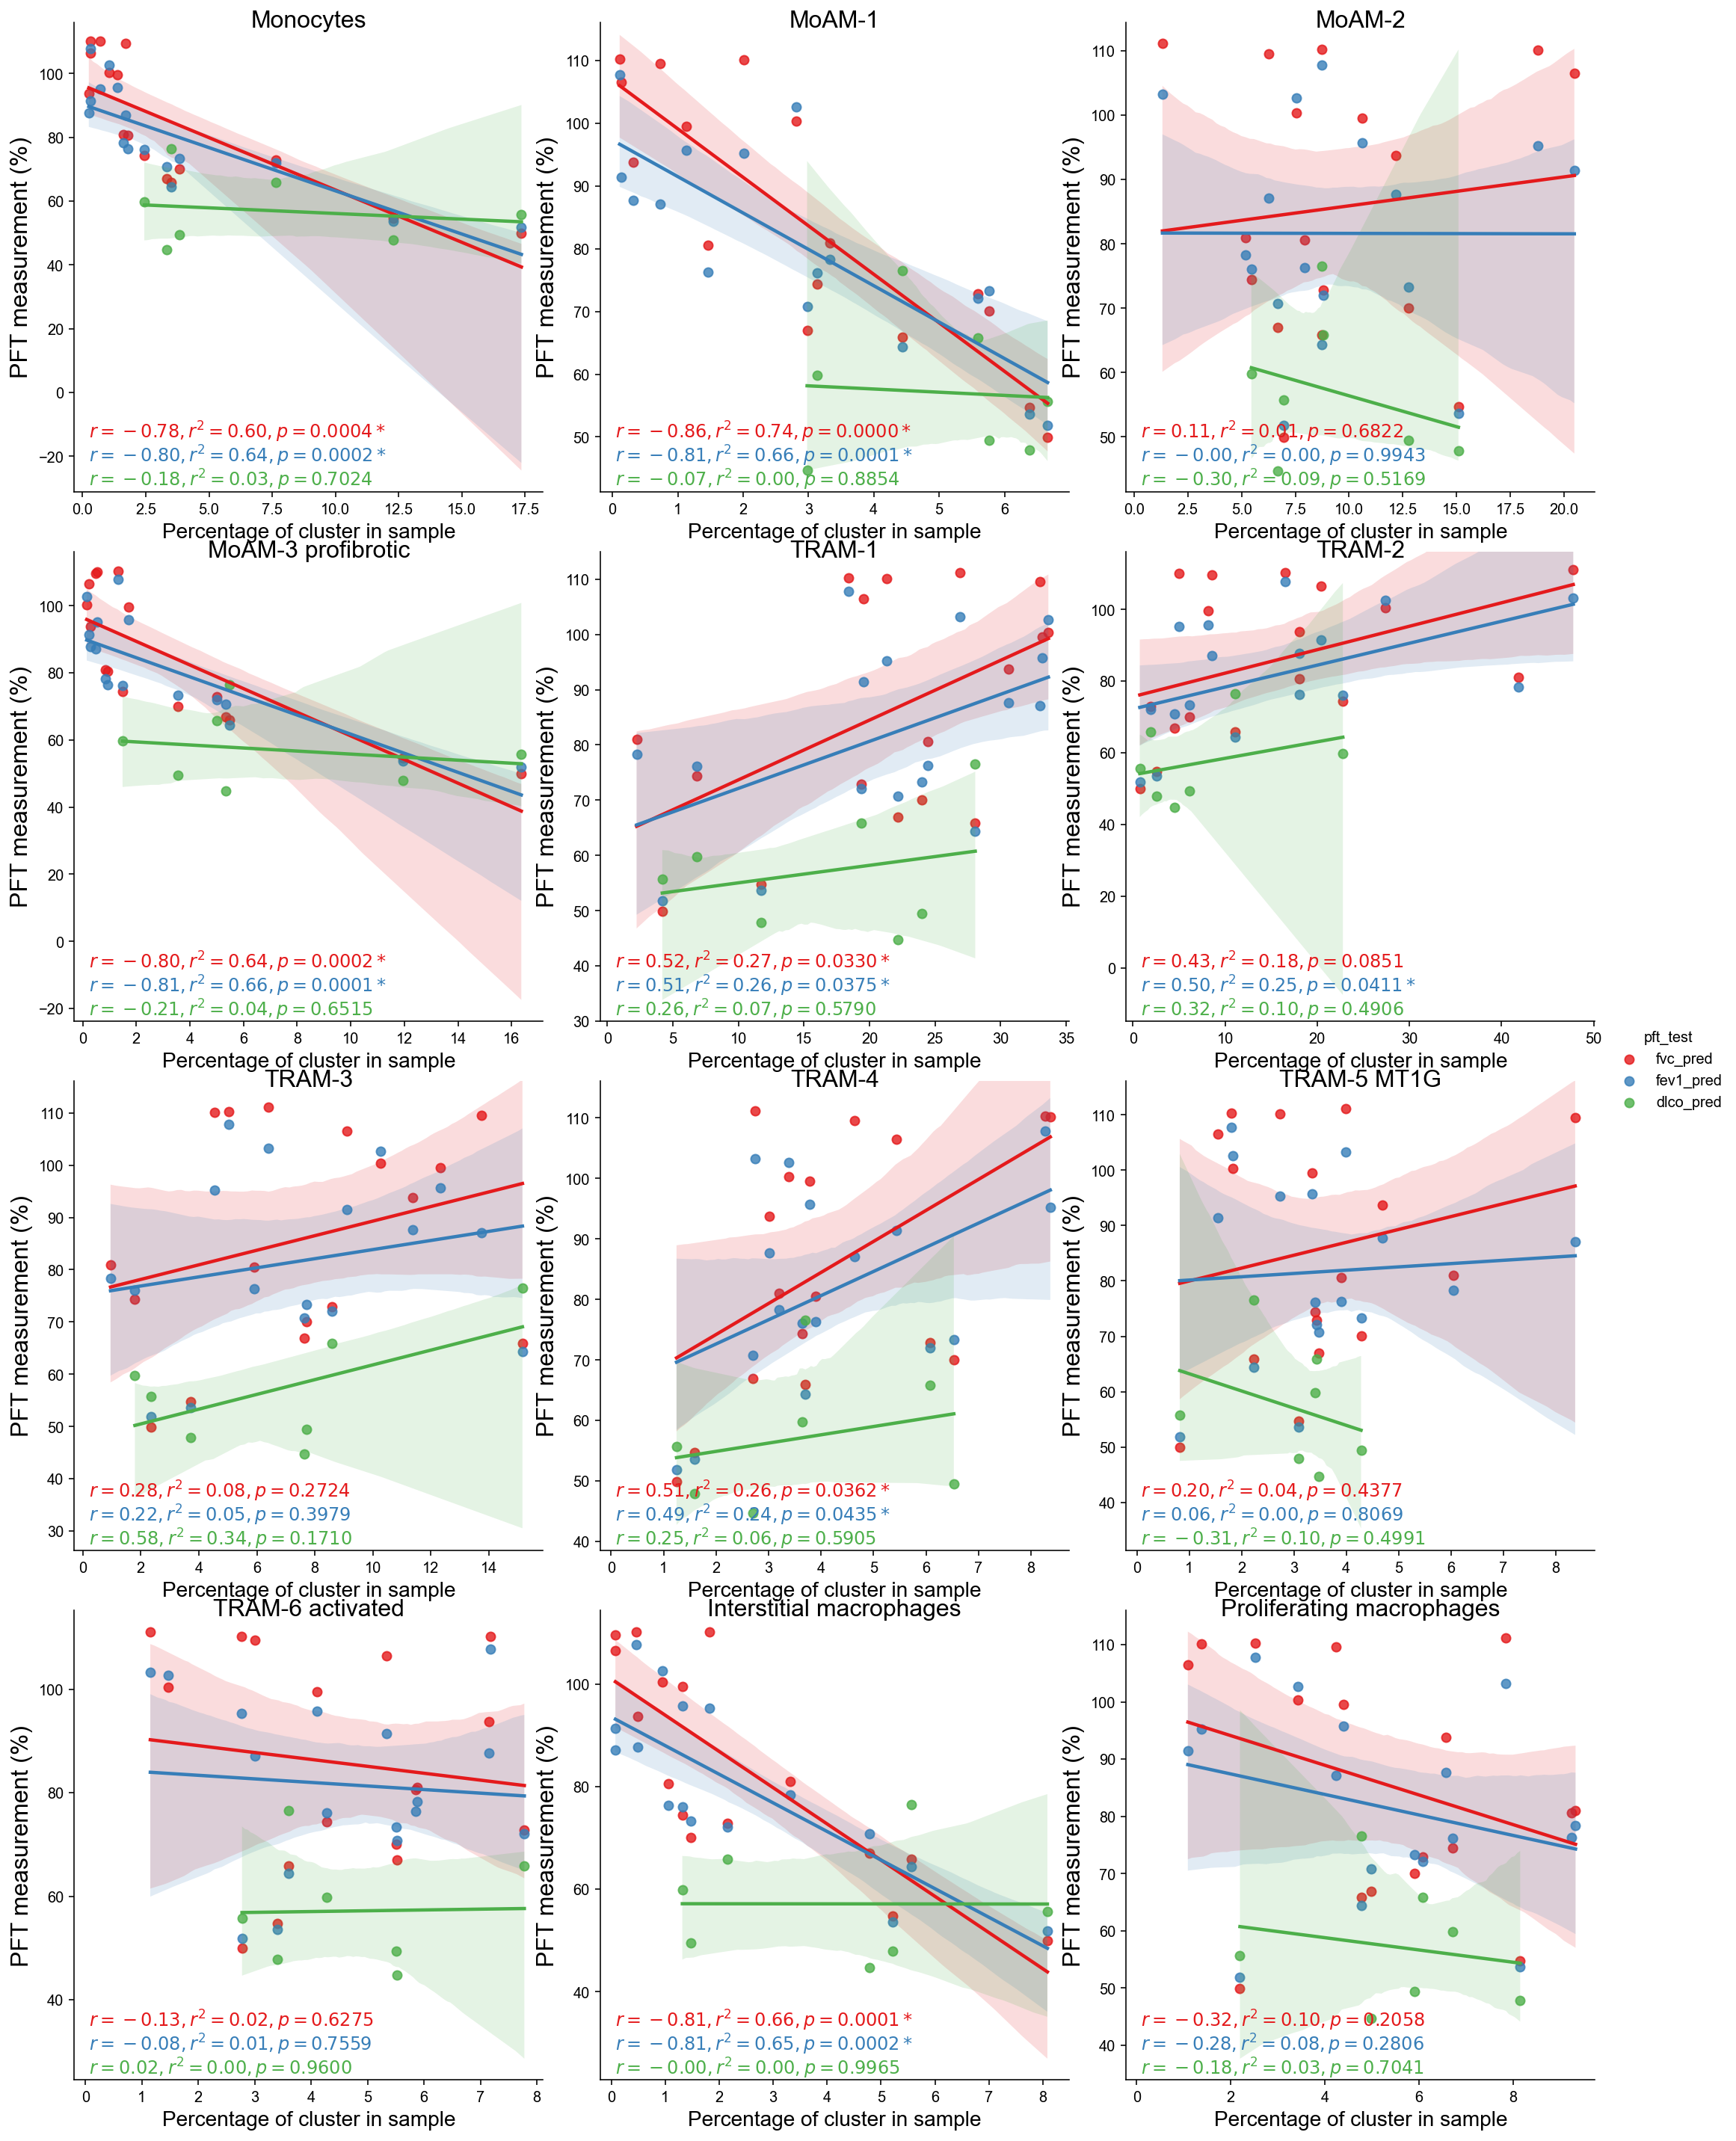

In [96]:
max_pft = df.loc[df.pft_test.isin(["fvc_pred", "fev1_pred", "dlco_pred"])].pft_measurement.max()
axes = sns.lmplot(
    data=df.loc[df.pft_test.isin(["fvc_pred", "fev1_pred", "dlco_pred"])],
    x="percent_in_sample",
    y="pft_measurement",
    col="cell_type",
    hue="pft_test",
    col_wrap=3,
    palette="Set1",
    facet_kws=dict(
        sharex=False,
        sharey=False
    )
)
for c, ax in axes.axes_dict.items():
    ax.set_title(c, fontsize=16, y=0.97)
    ax.set_xlabel(f"Percentage of cluster in sample", fontsize=14)
    ax.set_ylabel("PFT measurement (%)", fontsize=16)
    xmax = ax.get_xlim()[1]
    ax.set_xlim(-0.1 * (xmax / 8 + 1))
    ylim = ax.get_ylim()
    if ylim[1] > max_pft + 5:
        ax.set_ylim(ylim[0], max_pft + 5)
    for i, pft in enumerate(["fvc_pred", "fev1_pred", "dlco_pred"]):
        data = df.loc[(df.cell_type == c) & (df.pft_test == pft), :].dropna()
        x_fit = statsmodels.api.add_constant(data.percent_in_sample)
        res = statsmodels.api.OLS(data.pft_measurement, x_fit).fit()
        color = mpl.cm.Set1(i)
        r = np.corrcoef(data.percent_in_sample, data.pft_measurement)[0, 1]
        lm_str = f"$r={r:.2f}, r^2={res.rsquared:.2f}, p={res.pvalues[1]:.4f}$"
        if res.pvalues[1] < 0.05:
            lm_str = lm_str[:-1] + "*$"
        ax.annotate(
            lm_str,
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            (10, 16 * (2 - i) + 4),
            textcoords="offset points",
            fontsize=12,
            color=color
        )

There is no significant correlation with DLCO, so we remove that. We remove some cell types that didn't show any significant correlation as well.

**NB**! These plots now include healthy controls from Duke with healthy PFT measurements

In [50]:
df2 = df.loc[
    ~df.cell_type.isin(["TRAM-2", "TRAM-3", "TRAM-5 MT1G", "TRAM-6 activated"]),
    :
].copy()

In [51]:
df2.cell_type = df2.cell_type.cat.remove_unused_categories()

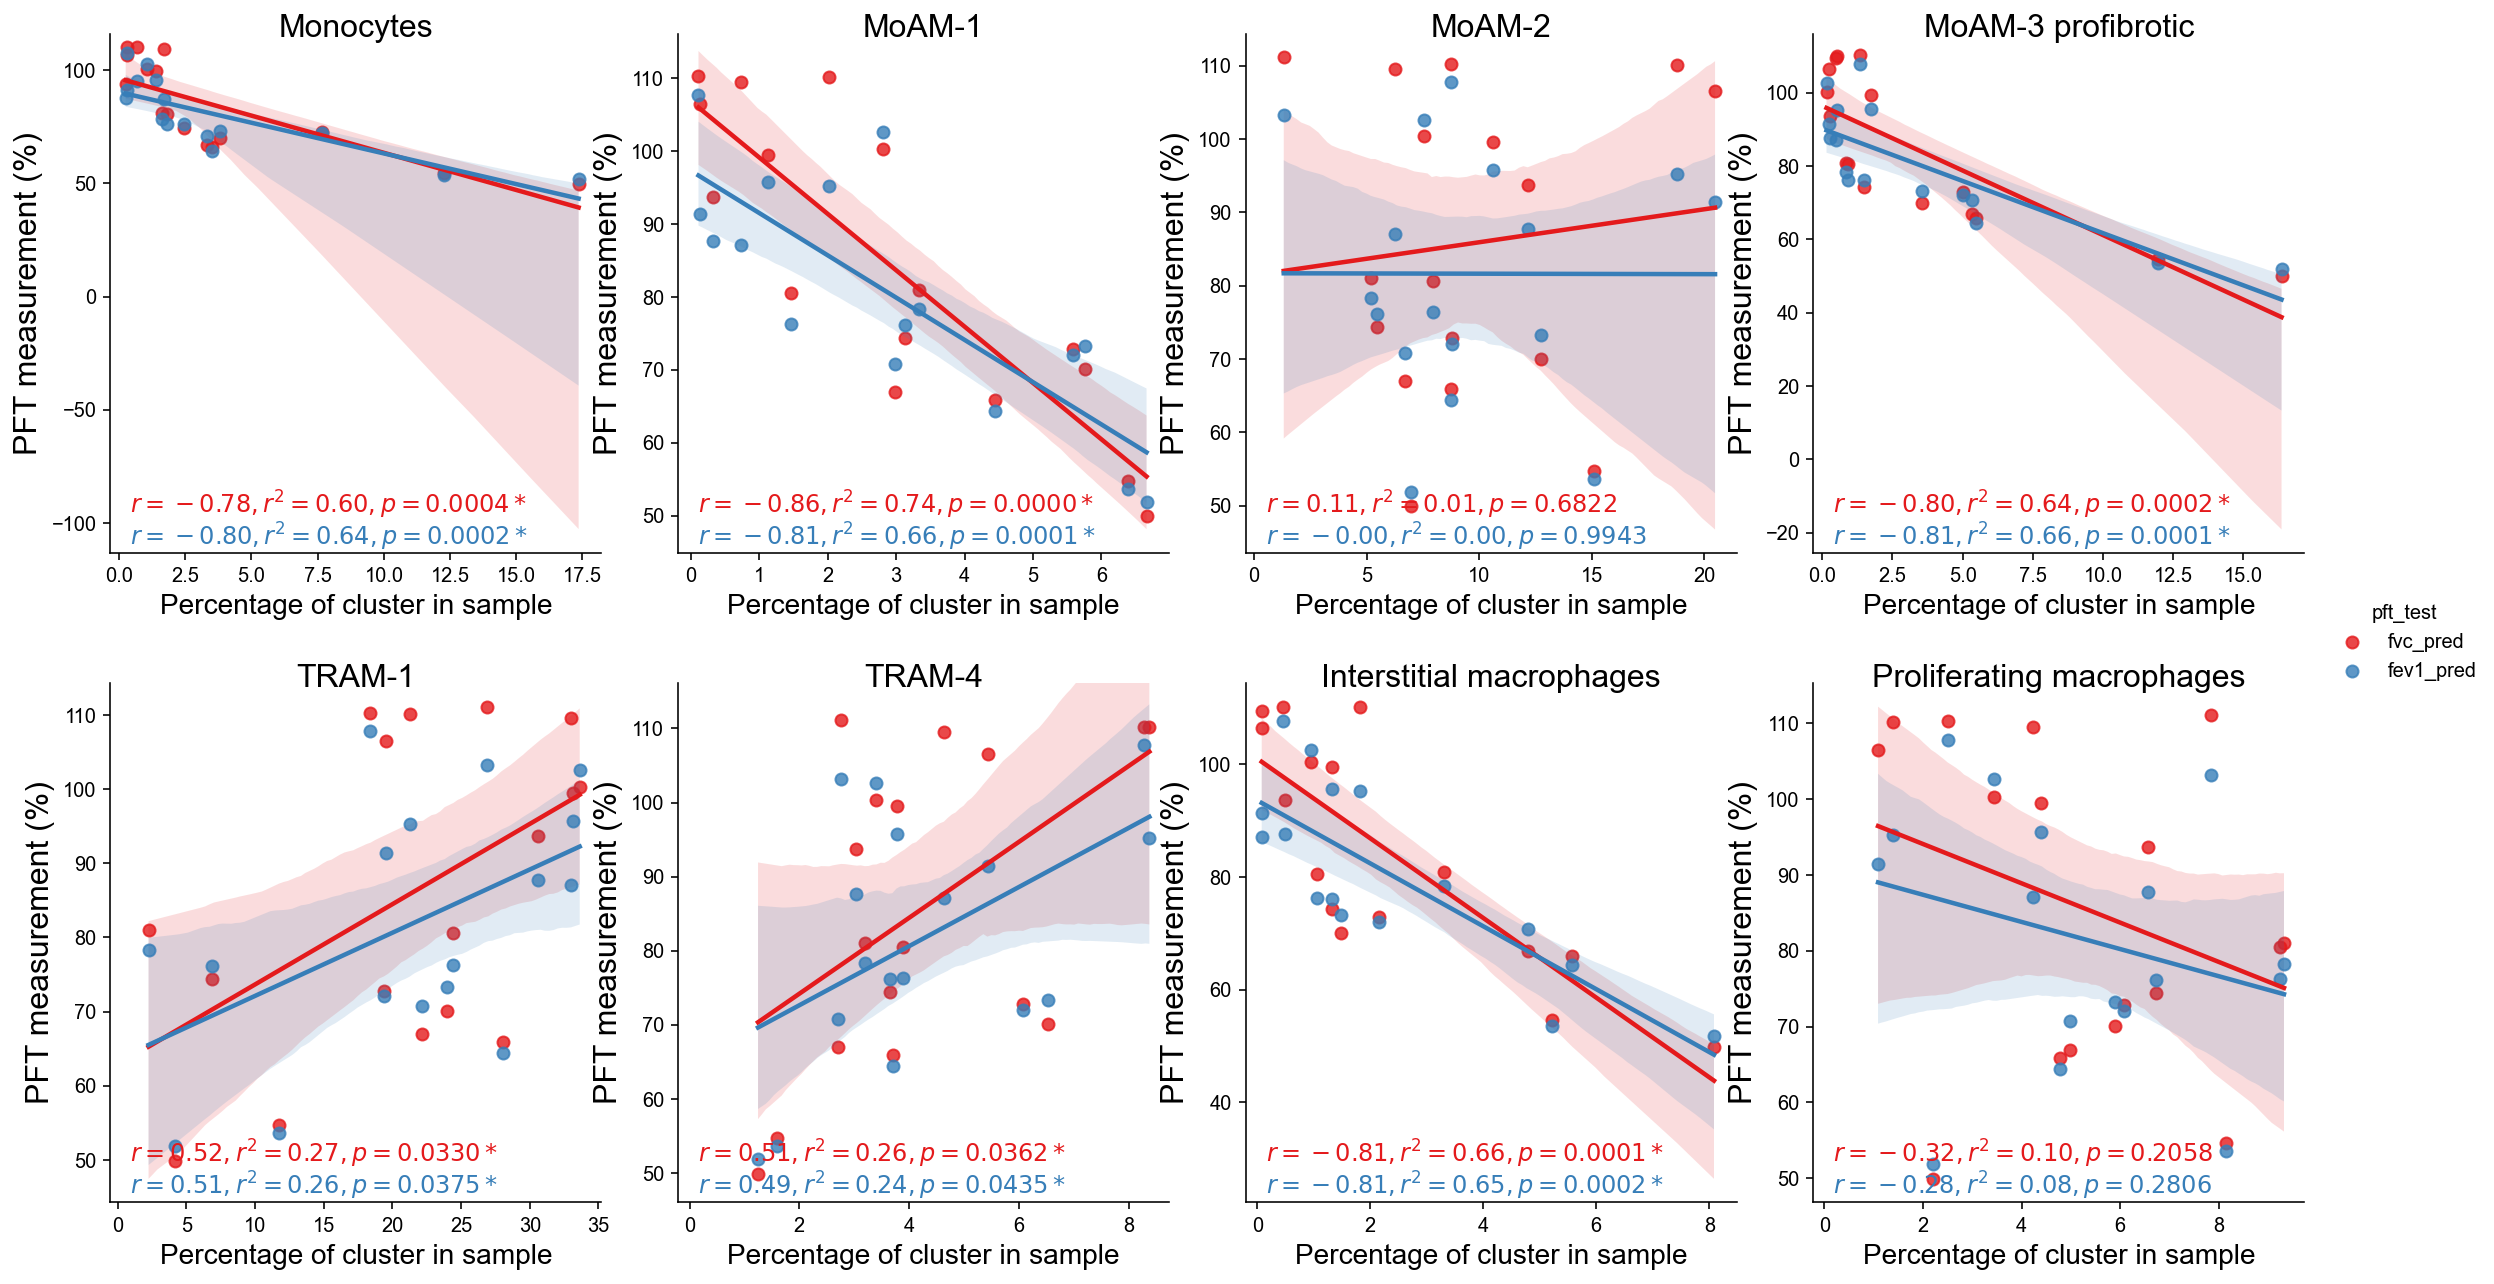

In [99]:
max_pft = df.loc[df.pft_test.isin(["fvc_pred", "fev1_pred", "dlco_pred"])].pft_measurement.max()
axes = sns.lmplot(
    data=df2.loc[df2.pft_test.isin(["fvc_pred", "fev1_pred"])],
    x="percent_in_sample",
    y="pft_measurement",
    col="cell_type",
    hue="pft_test",
    palette="Set1",
    col_wrap=4,
    facet_kws=dict(
        sharex=False,
        sharey=False,
#         row=2,
#         col=4,
        gridspec_kws=dict(
#             hspace=0.5,
#             nrows=2,
#             ncols=4
        )
    ),
    height=4.5,
    aspect=0.9
)
for c, ax in axes.axes_dict.items():
    ax.set_title(c, fontsize=16, y=0.97)
    ax.set_xlabel(f"Percentage of cluster in sample", fontsize=14)
    ax.set_ylabel("PFT measurement (%)", fontsize=16)
    xmax = ax.get_xlim()[1]
    ax.set_xlim(-0.1 * (xmax / 8 + 1))
    ylim = ax.get_ylim()
    if ylim[1] > max_pft + 5:
        ax.set_ylim(ylim[0], max_pft + 5)
    for i, pft in enumerate(["fvc_pred", "fev1_pred"]):
        data = df2.loc[(df2.cell_type == c) & (df2.pft_test == pft), :]
        x_fit = statsmodels.api.add_constant(data.percent_in_sample)
        res = statsmodels.api.OLS(data.pft_measurement, x_fit).fit()
        color = mpl.cm.Set1(i)
        r = np.corrcoef(data.percent_in_sample, data.pft_measurement)[0, 1]
        lm_str = f"$r={r:.2f}, r^2={res.rsquared:.2f}, p={res.pvalues[1]:.4f}$"
        if res.pvalues[1] < 0.05:
            lm_str = lm_str[:-1] + "*$"
        ax.annotate(
            lm_str,
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            (10, 16 * (1 - i) + 4),
            textcoords="offset points",
            fontsize=12,
            color=color
        )
axes.figure.subplots_adjust(hspace=0.25)

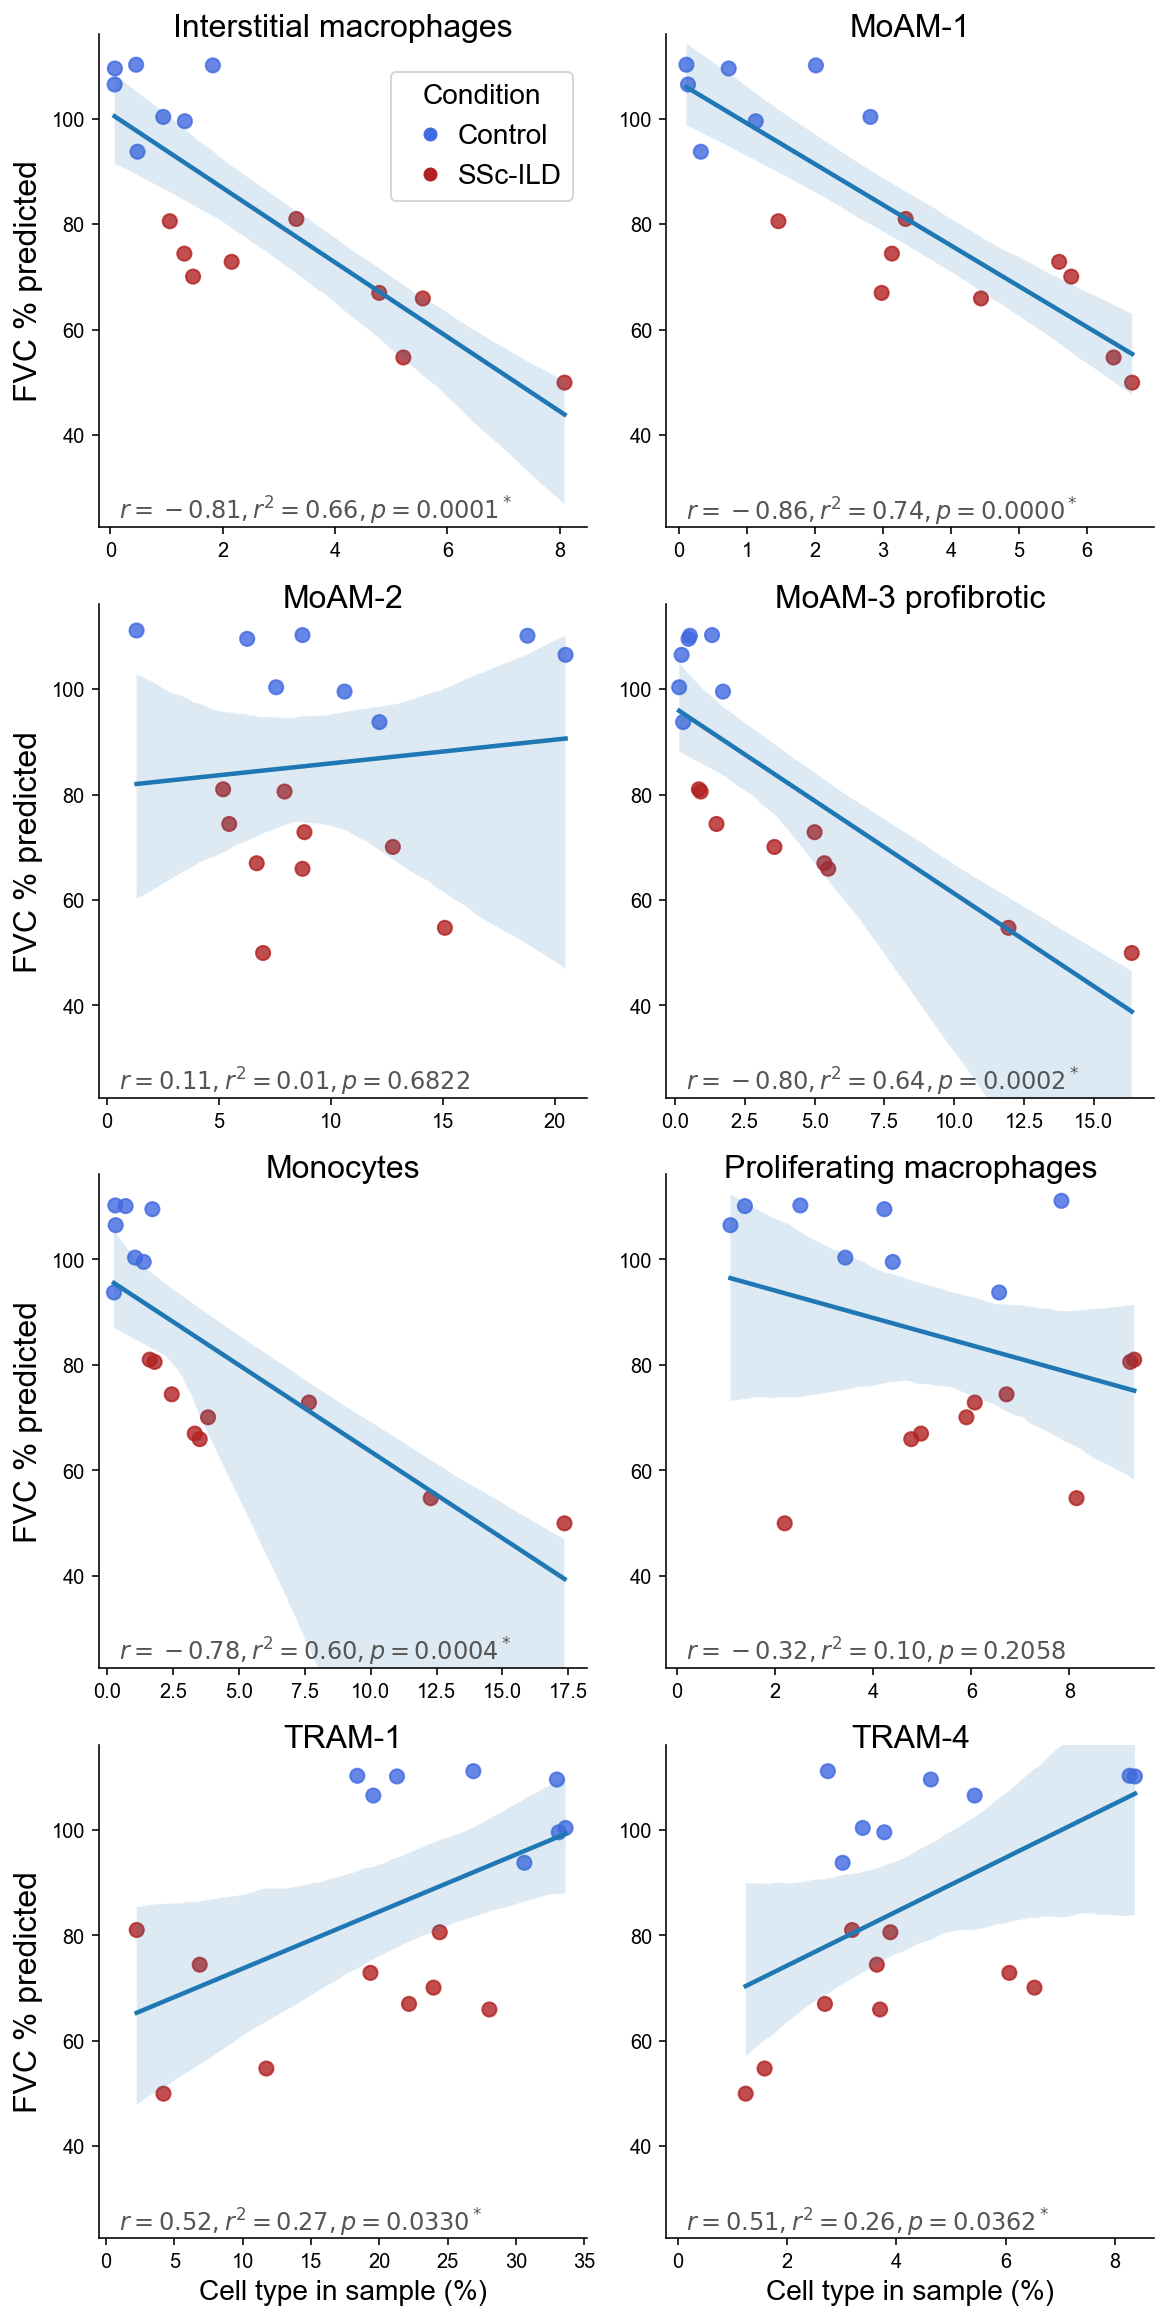

In [52]:
plot_df = df2.loc[df2.pft_test.eq('fvc_pred')]
max_pft = plot_df.pft_measurement.max()

fig, axes = plt.subplots(
    figsize=(8, 16),
    ncols=2,
    nrows=4,
    constrained_layout=True,
    gridspec_kw=dict(hspace=0),
    sharey=True
)

for i, ct in enumerate(plot_df.cell_type.cat.categories):
    ax = axes[i // 2, i % 2]
    sns.regplot(
        data=plot_df.loc[plot_df.cell_type.eq(ct)],
        x='percent_in_sample',
        y='pft_measurement',
        ax=ax,
        marker='.',
        scatter_kws=dict(
            color=[
                mpl.colors.hex2color(c)
                for c in plot_df.Status[plot_df.cell_type.eq(ct)].replace({'SSc-ILD': 'firebrick', 'Control': 'royalblue'})
            ],
            s=200,
        )
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(ct, fontsize=16, y=0.97)
    if i == 0:
        ax.legend(
            handles=[
                mpl.lines.Line2D([0], [0], marker='o', color='royalblue', label='Control', ls=''),
                mpl.lines.Line2D([0], [0], marker='o', color='firebrick', label='SSc-ILD', ls=''),
            ],
            fontsize=14,
            title='Condition',
            title_fontsize=14,
            handletextpad=0,
            loc='upper right',
            bbox_to_anchor=(1, 0.95)
        )
    if i < 6:
        ax.set_xlabel('')
    else:
        ax.set_xlabel(f'Cell type in sample (%)', fontsize=14)
    if i % 2 == 0:
        ax.set_ylabel('FVC % predicted', fontsize=16)
    else:
        ax.set_ylabel('')
    ax.tick_params(labelleft=True)
    xmax = ax.get_xlim()[1]
    ax.set_xlim(-0.1 * (xmax / 8 + 1))
    ylim = list(ax.get_ylim())
    if ylim[0] < 0:
        ylim[0] = -5
    if ylim[1] > max_pft + 5:
        ax.set_ylim(ylim[0], max_pft + 5)
    for i, pft in enumerate(["fvc_pred"]):
        data = plot_df.loc[plot_df.cell_type.eq(ct), :]
        x_fit = statsmodels.api.add_constant(data.percent_in_sample)
        res = statsmodels.api.OLS(data.pft_measurement, x_fit).fit()
        r = np.corrcoef(data.percent_in_sample, data.pft_measurement)[0, 1]
        lm_str = f"$r={r:.2f}, r^2={res.rsquared:.2f}, p={res.pvalues[1]:.4f}$"
        if res.pvalues[1] < 0.05:
            lm_str = lm_str[:-1] + "^*$"
        ax.annotate(
            lm_str,
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            (10, 16 * (0 - i) + 4),
            textcoords="offset points",
            fontsize=12,
            color='#555'
        )
fig.savefig('00_figures/Figure_1E_fvc_corr.pdf')

Check these correlations without healthy controls

In [ ]:
# Filter data to exclude healthy controls
ssc_only_df = plot_df[plot_df.Status == "SSc-ILD"].copy()

# Create a dataframe to store correlation results
corr_results = []

# Calculate correlation for each cell type
for ct in ssc_only_df.cell_type.cat.categories:
    ct_data = ssc_only_df[ssc_only_df.cell_type == ct]
    if len(ct_data) < 3:  # Skip if not enough data points
        continue

    # Calculate correlation
    x_fit = statsmodels.api.add_constant(ct_data.percent_in_sample)
    res = statsmodels.api.OLS(ct_data.pft_measurement, x_fit).fit()
    r = np.corrcoef(ct_data.percent_in_sample, ct_data.pft_measurement)[0, 1]

    # Store results
    corr_results.append({
        'cell_type': ct,
        'correlation': r,
        'r_squared': res.rsquared,
        'p_value': res.pvalues[1],
        'sample_count': len(ct_data)
    })

# Convert to dataframe and sort by p-value
corr_df = pd.DataFrame(corr_results)
corr_df = corr_df.sort_values('p_value')

# Add significance indicator
corr_df['significant'] = corr_df.p_value < 0.05

corr_df.to_csv('00_figures/Figure_1F_fvc_corr.csv', index=False)

# Display results
corr_df

cell_type  correlation  r_squared   p_value  sample_count  \
3         MoAM-3 profibrotic    -0.966538   0.934195  0.000022             9   
0                  Monocytes    -0.882524   0.778848  0.001628             9   
6   Interstitial macrophages    -0.830921   0.690429  0.005524             9   
1                     MoAM-1    -0.763257   0.582561  0.016714             9   
7  Proliferating macrophages     0.668492   0.446881  0.049017             9   
5                     TRAM-4     0.572506   0.327763  0.107171             9   
2                     MoAM-2    -0.421245   0.177447  0.258829             9   
4                     TRAM-1     0.169027   0.028570  0.663754             9   

   significant  
3         True  
0         True  
6         True  
1         True  
7         True  
5        False  
2        False  
4        False

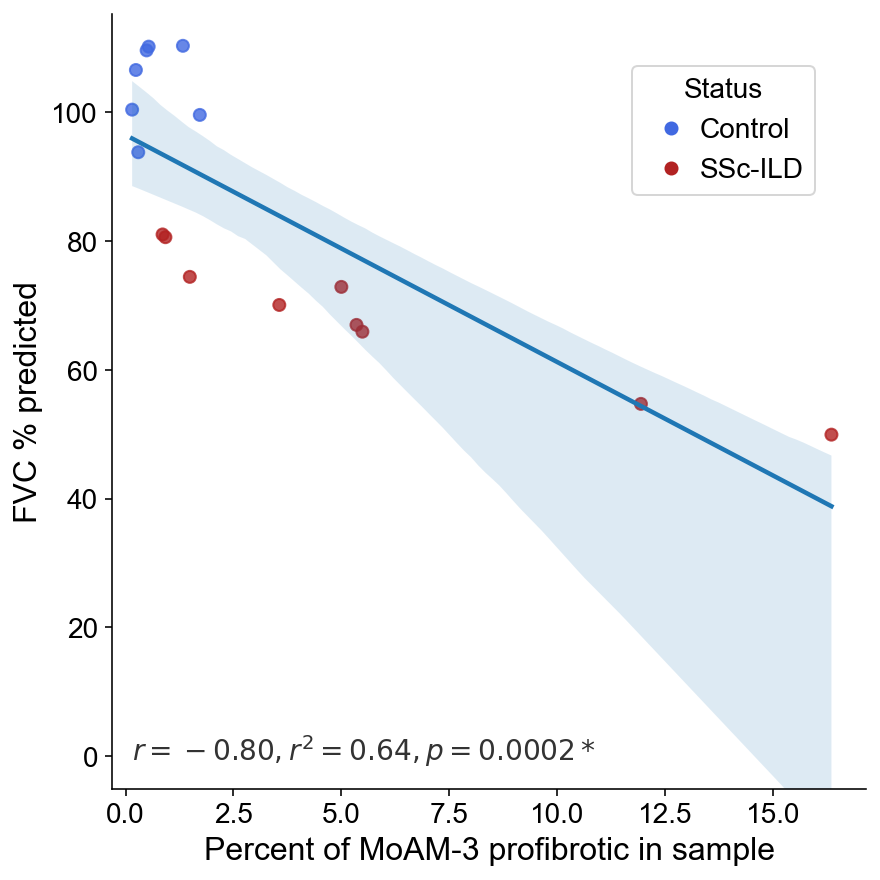

In [ ]:
plot_df = df2.loc[df2.pft_test.eq('fvc_pred') & df2.cell_type.eq('MoAM-3 profibrotic')].copy()
plot_df.cell_type = plot_df.cell_type.cat.remove_unused_categories()
max_pft = plot_df.pft_measurement.max()

fig, ax = plt.subplots(
    figsize=(6, 6),
    constrained_layout=True,
    # gridspec_kw=dict(hspace=0.25),
    # sharey=True
)

for i, ct in enumerate(plot_df.cell_type.cat.categories):
    sns.regplot(
        data=plot_df.loc[plot_df.cell_type.eq(ct)],
        x='percent_in_sample',
        y='pft_measurement',
        ax=ax,
        scatter_kws=dict(
            color=[
                mpl.colors.hex2color(c)
                for c in plot_df.Status[plot_df.cell_type.eq(ct)].replace({'SSc-ILD': 'firebrick', 'Control': 'royalblue'})
            ]
        )
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(
        handles=[
            mpl.lines.Line2D([0], [0], marker='o', color='royalblue', label='Control', ls=''),
            mpl.lines.Line2D([0], [0], marker='o', color='firebrick', label='SSc-ILD', ls=''),
        ],
        fontsize=14,
        title='Status',
        title_fontsize=14,
        handletextpad=0,
        loc='upper right',
        bbox_to_anchor=(0.95, 0.95)
    )
    ax.set_xlabel(f'Percent of {ct} in sample', fontsize=16)
    ax.set_ylabel('FVC % predicted', fontsize=16)
    ax.tick_params(labelleft=True, labelsize=14)
    xmax = ax.get_xlim()[1]
    ax.set_xlim(-0.1 * (xmax / 8 + 1))
    ylim = list(ax.get_ylim())
    if ylim[0] < 0:
        ylim[0] = -5
    if ylim[1] > max_pft + 5:
        ax.set_ylim(ylim[0], max_pft + 5)
    for i, pft in enumerate(["fvc_pred"]):
        data = plot_df.loc[plot_df.cell_type.eq(ct), :]
        x_fit = statsmodels.api.add_constant(data.percent_in_sample)
        res = statsmodels.api.OLS(data.pft_measurement, x_fit).fit()
        r = np.corrcoef(data.percent_in_sample, data.pft_measurement)[0, 1]
        lm_str = f"$r={r:.2f}, r^2={res.rsquared:.2f}, p={res.pvalues[1]:.4f}$"
        if res.pvalues[1] < 0.05:
            lm_str = lm_str[:-1] + "*$"
        ax.annotate(
            lm_str,
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            (10, 16 * (0 - i) + 14),
            textcoords="offset points",
            fontsize=14,
            color='#333'
        )
fig.savefig('00_figures/Figure_3_panel_E_fvc_corr_ats.pdf')

### For a grant

In [106]:
df2

cell_type  percent_in_sample External Sample ID  \
0      Interstitial macrophages           3.310478           SSc_SSc6   
1                        MoAM-1           3.331905           SSc_SSc6   
2                 MoAM-2 mature           5.185344           SSc_SSc6   
3            MoAM-3 profibrotic           0.857082           SSc_SSc6   
4                     Monocytes           1.607028           SSc_SSc6   
...                         ...                ...                ...   
1139         MoAM-3 profibrotic           3.562598          SSc_SSc10   
1140                  Monocytes           3.821083          SSc_SSc10   
1141  Proliferating macrophages           5.900202          SSc_SSc10   
1142                     TRAM-1          23.971679          SSc_SSc10   
1145                     TRAM-4           6.529557          SSc_SSc10   

       Status     pft_test  pft_measurement  
0     SSc-ILD     fvc_pred        80.987043  
1     SSc-ILD     fvc_pred        80.987043  
2     SSc-ILD     fvc_pred        80.987043  
3     SSc-ILD     fvc_pred        80.987043  
4     SSc-ILD     fvc_pred        80.987043  
...       ...          ...              ...  
1139  SSc-ILD  k_score_fib         2.600000  
1140  SSc-ILD  k_score_fib         2.600000  
1141  SSc-ILD  k_score_fib         2.600000  
1142  SSc-ILD  k_score_fib         2.600000  
1145  SSc-ILD  k_score_fib         2.600000  

[464 rows x 6 columns]

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


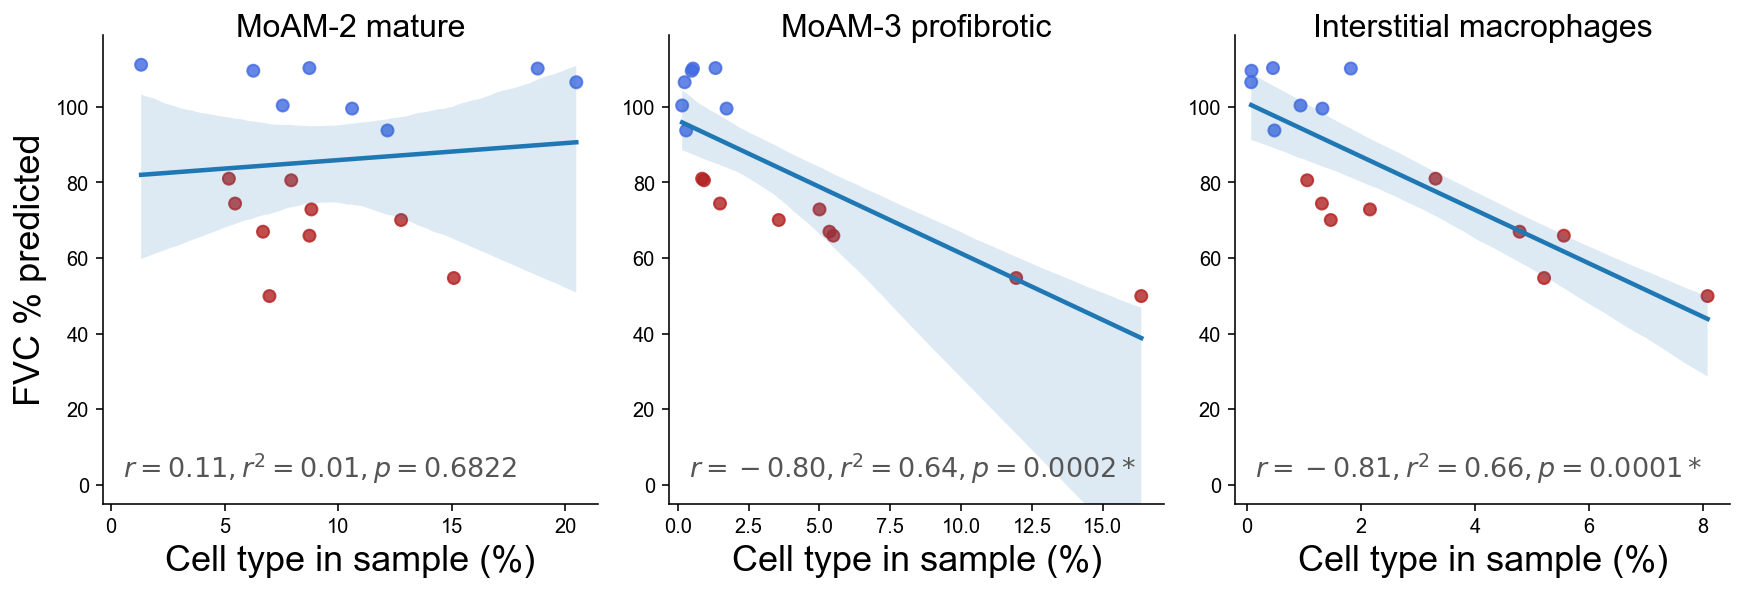

In [ ]:
plot_df = df2.loc[df2.pft_test.eq('fvc_pred') & df2.cell_type.isin([
    'MoAM-2 mature',
    'MoAM-3 profibrotic',
    'Interstitial macrophages'
])]
plot_df.cell_type = plot_df.cell_type.cat.remove_unused_categories()
max_pft = plot_df.pft_measurement.max()

fig, axes = plt.subplots(
    figsize=(12, 4),
    ncols=3,
    nrows=1,
    constrained_layout=True,
    # gridspec_kw=dict(hspace=0.25),
    sharey=True
)

for i, ct in enumerate(plot_df.cell_type.cat.categories):
    ax = axes[i]
    sns.regplot(
        data=plot_df.loc[plot_df.cell_type.eq(ct)],
        x='percent_in_sample',
        y='pft_measurement',
        ax=ax,
        scatter_kws=dict(
            color=[
                mpl.colors.hex2color(c)
                for c in plot_df.Status[plot_df.cell_type.eq(ct)].replace({
                    'SSc-ILD': 'firebrick',
                    'Control': 'royalblue'
                })
            ]
        )
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(ct, fontsize=16, y=0.97)
    if i == 3:
        ax.legend(
            handles=[
                mpl.lines.Line2D([0], [0], marker='o', color='royalblue', label='Control', ls=''),
                mpl.lines.Line2D([0], [0], marker='o', color='firebrick', label='SSc-ILD', ls=''),
            ],
            fontsize=14,
            title='Condition',
            title_fontsize=14,
            handletextpad=0,
            loc='upper right',
            bbox_to_anchor=(1, 0.95)
        )
    ax.set_xlabel(f'Cell type in sample (%)', fontsize=18)
    if i % 4 == 0:
        ax.set_ylabel('FVC % predicted', fontsize=18)
    else:
        ax.set_ylabel('')
    ax.tick_params(labelleft=True)
    xmax = ax.get_xlim()[1]
    ax.set_xlim(-0.1 * (xmax / 8 + 1))
    ylim = list(ax.get_ylim())
    if ylim[0] < 0:
        ylim[0] = -5
    ax.set_ylim(-5, max_pft + 8)
    for i, pft in enumerate(["fvc_pred"]):
        data = plot_df.loc[plot_df.cell_type.eq(ct), :]
        x_fit = statsmodels.api.add_constant(data.percent_in_sample)
        res = statsmodels.api.OLS(data.pft_measurement, x_fit).fit()
        r = np.corrcoef(data.percent_in_sample, data.pft_measurement)[0, 1]
        lm_str = f"$r={r:.2f}, r^2={res.rsquared:.2f}, p={res.pvalues[1]:.4f}$"
        if res.pvalues[1] < 0.05:
            lm_str = lm_str[:-1] + "*$"
        ax.annotate(
            lm_str,
            (ax.get_xlim()[0], 0),
            (10, 16 * (0 - i) + 4),
            textcoords="offset points",
            fontsize=13.5,
            color='#555'
        )
fig.savefig('00_figures/Figure_2F_fvc_corr_for_grant.pdf')

## 2.2 Correlation with HRCT

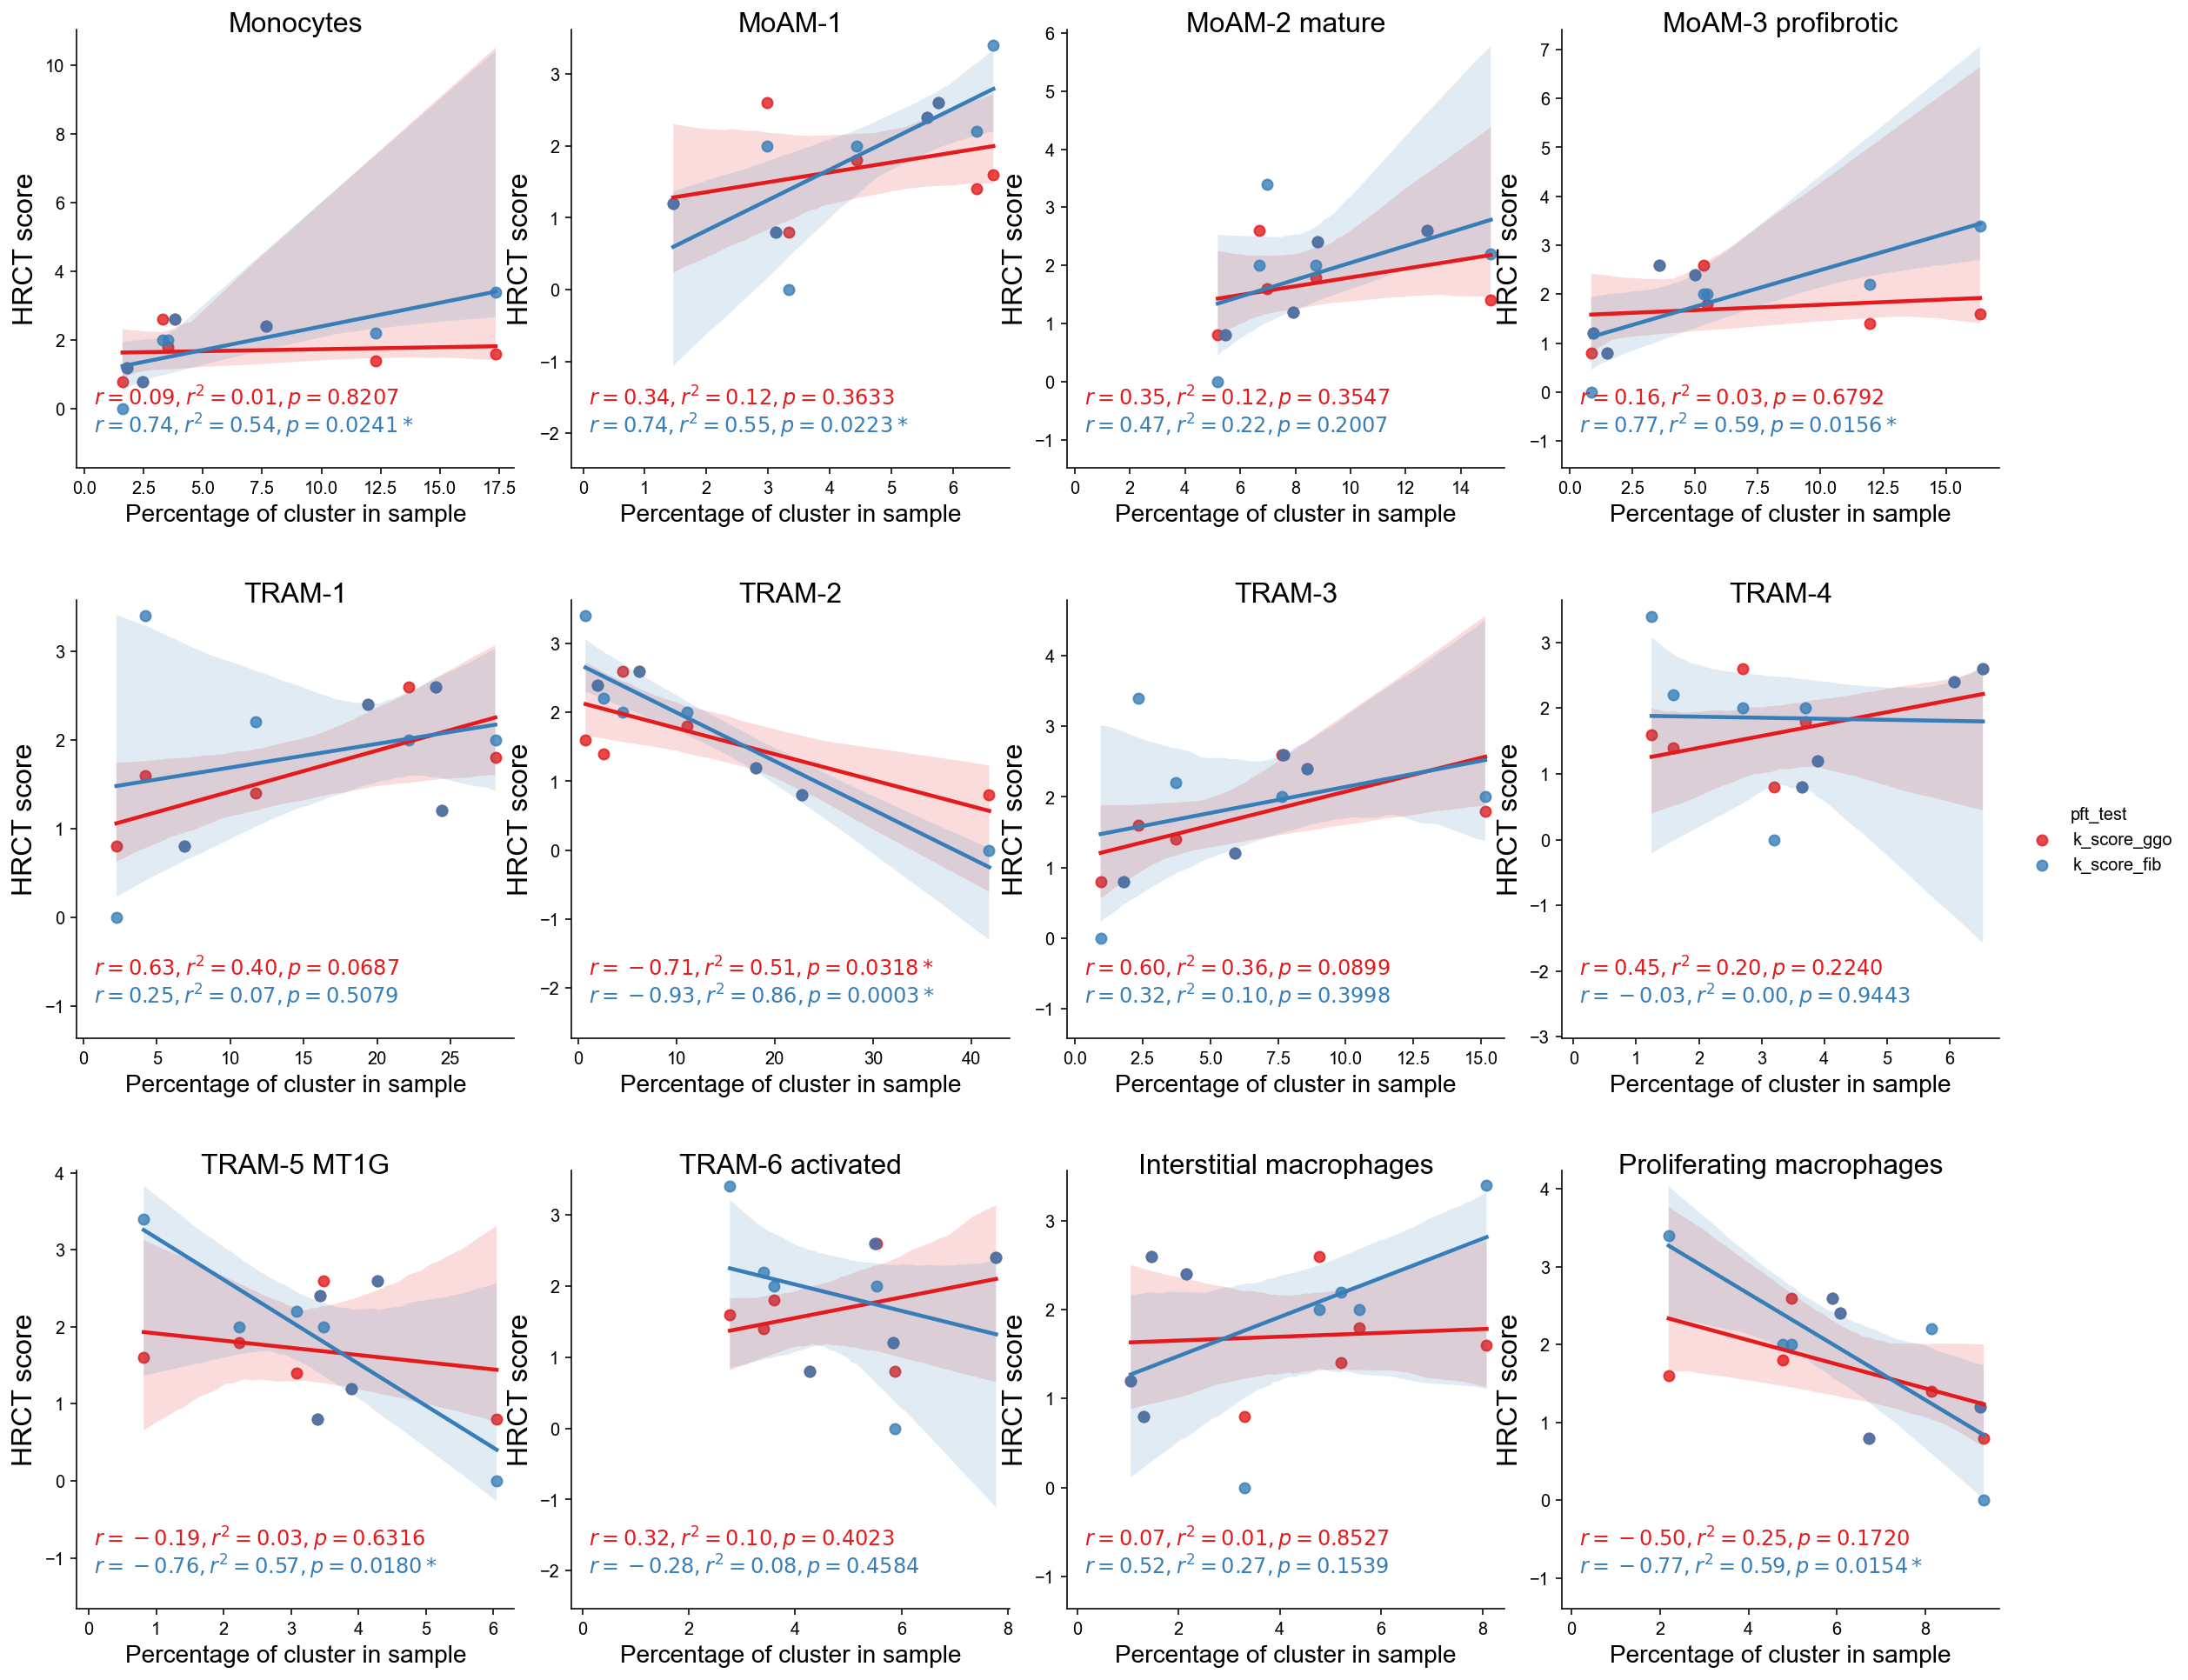

In [ ]:
axes = sns.lmplot(
    data=df.loc[df.pft_test.isin(['k_score_ggo', 'k_score_fib'])],
    x="percent_in_sample",
    y="pft_measurement",
    col="cell_type",
    hue="pft_test",
    palette="Set1",
    col_wrap=4,
    facet_kws=dict(
        sharex=False,
        sharey=False,
#         row=2,
#         col=4,
        gridspec_kws=dict(
#             hspace=0.5,
#             nrows=2,
#             ncols=4
        )
    ),
    height=4.5,
    aspect=0.9
)
for c, ax in axes.axes_dict.items():
    ax.set_title(c, fontsize=16, y=0.97)
    ax.set_xlabel(f"Percentage of cluster in sample", fontsize=14)
    ax.set_ylabel("HRCT score", fontsize=16)
    xmax = ax.get_xlim()[1]
    ax.set_xlim(-0.1 * (xmax / 8 + 1))
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0] - 1.2, ylim[1])
    # if ylim[1] > max_pft + 5:
    #     ax.set_ylim(ylim[0], max_pft + 5)
    for i, pft in enumerate(['k_score_ggo', 'k_score_fib']):
        data = df.loc[(df.cell_type == c) & (df.pft_test == pft), :]
        x_fit = statsmodels.api.add_constant(data.percent_in_sample)
        res = statsmodels.api.OLS(data.pft_measurement, x_fit).fit()
        color = mpl.cm.Set1(i)
        r = np.corrcoef(data.percent_in_sample, data.pft_measurement)[0, 1]
        lm_str = f"$r={r:.2f}, r^2={res.rsquared:.2f}, p={res.pvalues[1]:.4f}$"
        if res.pvalues[1] < 0.05:
            lm_str = lm_str[:-1] + "*$"
        ax.annotate(
            lm_str,
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            (10, 16 * (2 - i) + 4),
            textcoords="offset points",
            fontsize=12,
            color=color
        )
axes.figure.subplots_adjust(hspace=0.3)

In [53]:
df2 = df.loc[
    ~df.cell_type.isin(["TRAM-1", "TRAM-3", "TRAM-4", "TRAM-6 activated"]),
    :
].copy()

In [54]:
df2.cell_type = df2.cell_type.cat.remove_unused_categories()

In [55]:
df2

cell_type  percent_in_sample External Sample ID  \
0      Interstitial macrophages           3.310478           SSc_SSc6   
1                        MoAM-1           3.331905           SSc_SSc6   
2                        MoAM-2           5.185344           SSc_SSc6   
3            MoAM-3 profibrotic           0.857082           SSc_SSc6   
4                     Monocytes           1.607028           SSc_SSc6   
...                         ...                ...                ...   
1139         MoAM-3 profibrotic           3.562598          SSc_SSc10   
1140                  Monocytes           3.821083          SSc_SSc10   
1141  Proliferating macrophages           5.900202          SSc_SSc10   
1143                     TRAM-2           6.181164          SSc_SSc10   
1146                TRAM-5 MT1G           4.281861          SSc_SSc10   

       Status     pft_test  pft_measurement  
0     SSc-ILD     fvc_pred        80.987043  
1     SSc-ILD     fvc_pred        80.987043  
2     SSc-ILD     fvc_pred        80.987043  
3     SSc-ILD     fvc_pred        80.987043  
4     SSc-ILD     fvc_pred        80.987043  
...       ...          ...              ...  
1139  SSc-ILD  k_score_fib         2.600000  
1140  SSc-ILD  k_score_fib         2.600000  
1141  SSc-ILD  k_score_fib         2.600000  
1143  SSc-ILD  k_score_fib         2.600000  
1146  SSc-ILD  k_score_fib         2.600000  

[464 rows x 6 columns]

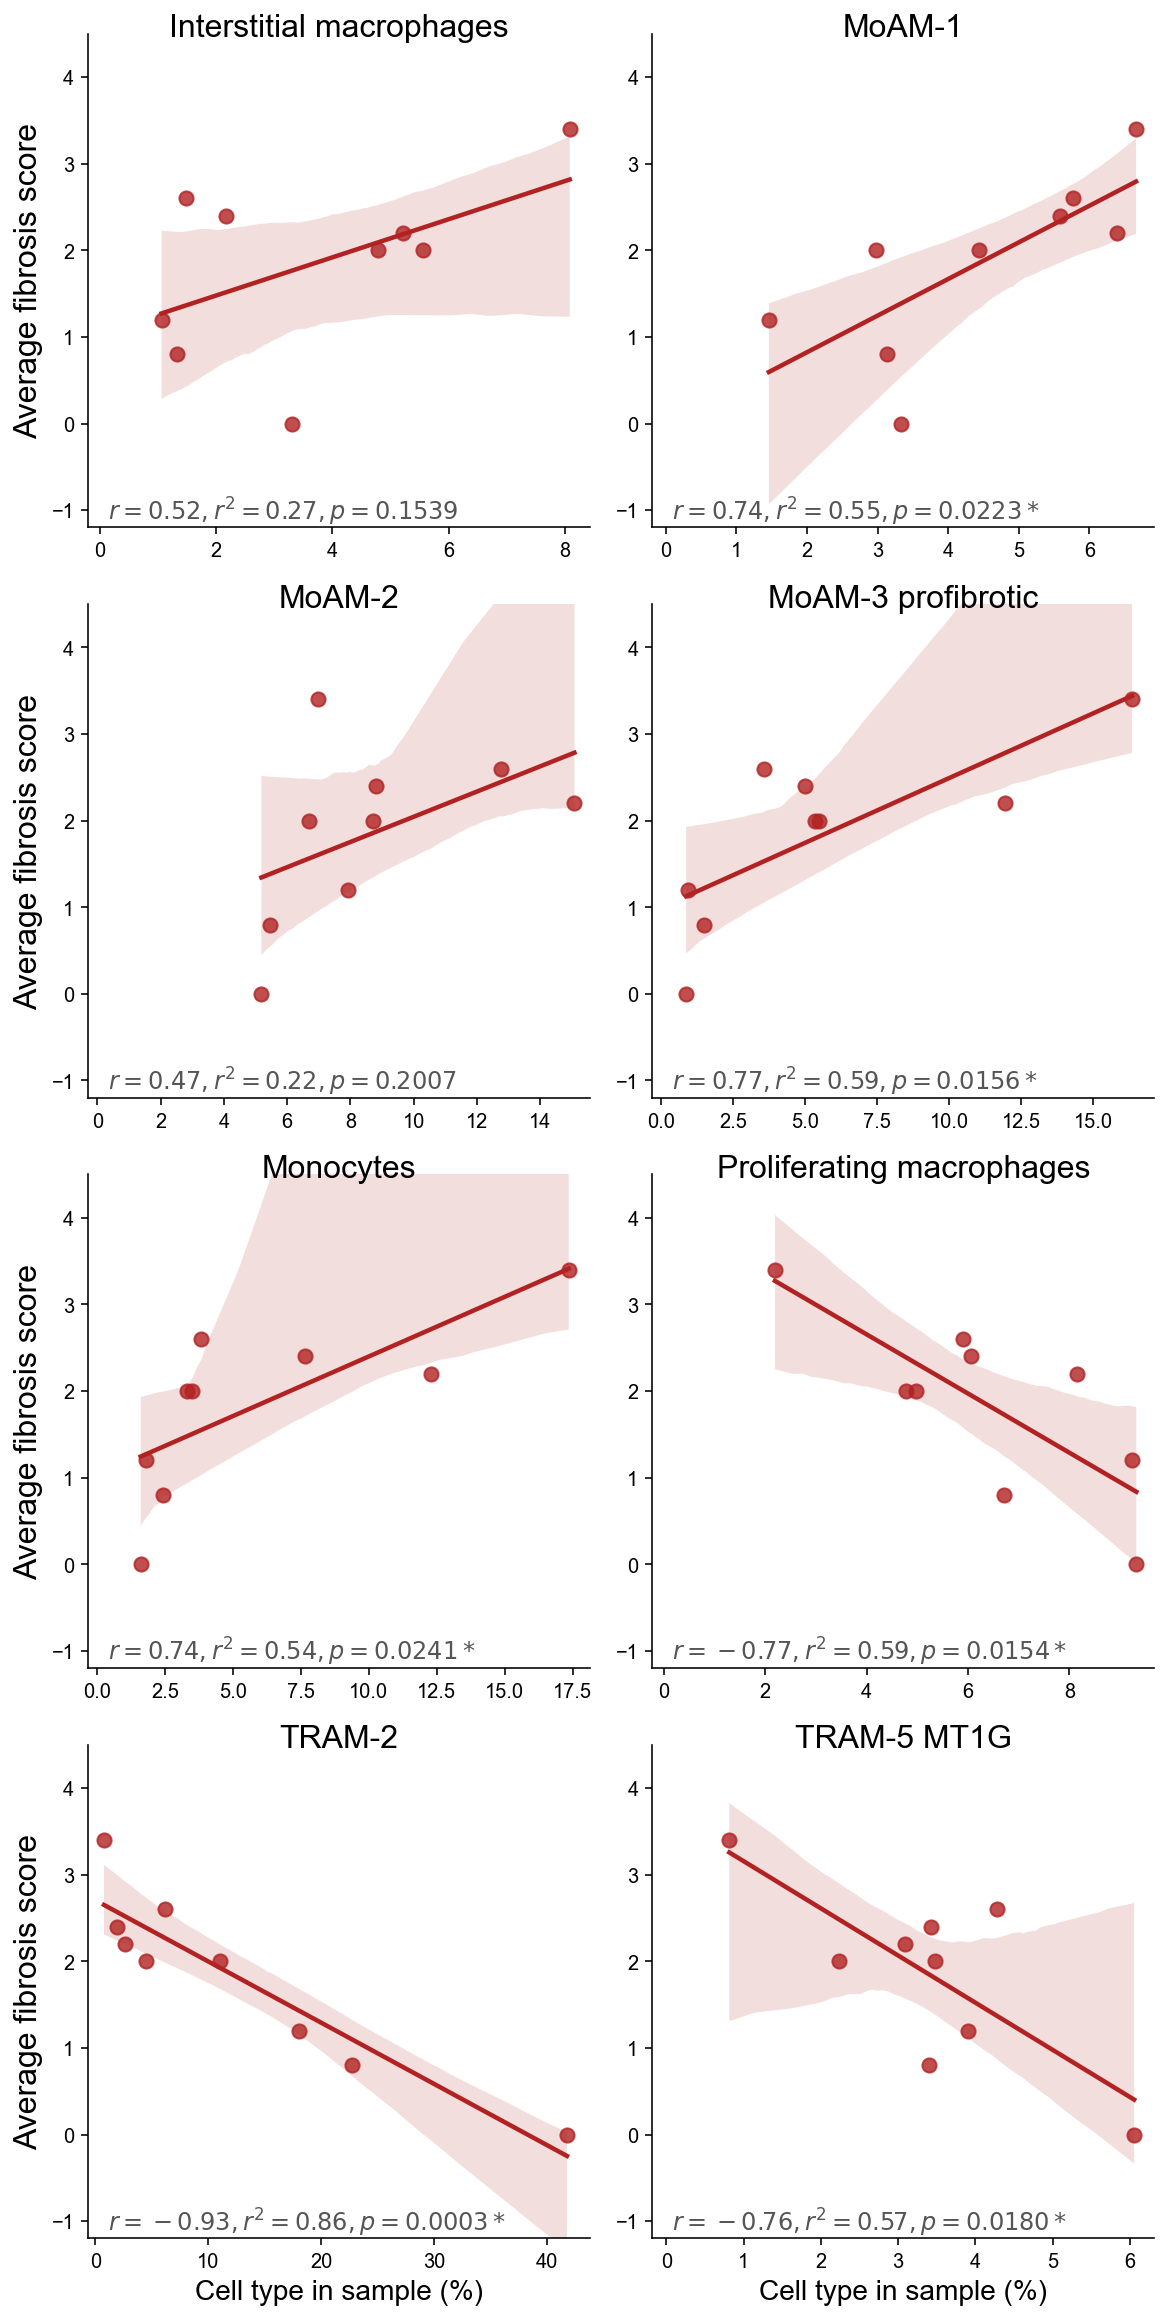

In [58]:
#max_pft = df.loc[df.pft_test.isin(["fvc_pred", "fev1_pred", "pft_dlco_pred"])].pft_measurement.max()
fig, axes = plt.subplots(
    figsize=(8, 16),
    ncols=2,
    nrows=4,
    constrained_layout=True,
    gridspec_kw=dict(hspace=0),
    sharey=True
)

for i, ct in enumerate(df2.cell_type.cat.categories):
    ax = axes[i // 2, i % 2]
    sns.regplot(
        data=df2.loc[df2.cell_type.eq(ct) & df2.pft_test.eq('k_score_fib')],
        x='percent_in_sample',
        y='pft_measurement',
        ax=ax,
        marker='.',
        color='firebrick',
        scatter_kws=dict(
            color='firebrick',
            s=200,
        )
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(ct, fontsize=16, y=0.97)

    if i > 5:
        ax.set_xlabel(f'Cell type in sample (%)', fontsize=14)
    else:
        ax.set_xlabel('')
    if i % 2 == 0:
        ax.set_ylabel('Average fibrosis score', fontsize=16)
    else:
        ax.set_ylabel('')
    xmax = ax.get_xlim()[1]
    ax.tick_params(labelleft=True)
    ax.set_xlim(-0.1 * (xmax / 8 + 1))
    ax.set_ylim(-1.2, 4.5)
    # if ylim[1] > max_pft + 5:
    #     ax.set_ylim(ylim[0], max_pft + 5)
    for i, pft in enumerate(['k_score_fib']):
        data = df.loc[(df.cell_type == ct) & (df.pft_test == pft), :]
        x_fit = statsmodels.api.add_constant(data.percent_in_sample)
        res = statsmodels.api.OLS(data.pft_measurement, x_fit).fit()
        r = np.corrcoef(data.percent_in_sample, data.pft_measurement)[0, 1]
        lm_str = f"$r={r:.2f}, r^2={res.rsquared:.2f}, p={res.pvalues[1]:.4f}$"
        if res.pvalues[1] < 0.05:
            lm_str = lm_str[:-1] + "*$"
        ax.annotate(
            lm_str,
            (ax.get_xlim()[0], ax.get_ylim()[0]),
            (10, 4),
            textcoords="offset points",
            fontsize=12,
            color='#555'
        )
# axes.figure.subplots_adjust(hspace=0.3)
fig.savefig('00_figures/Figure_1F_hrct_corr.pdf')

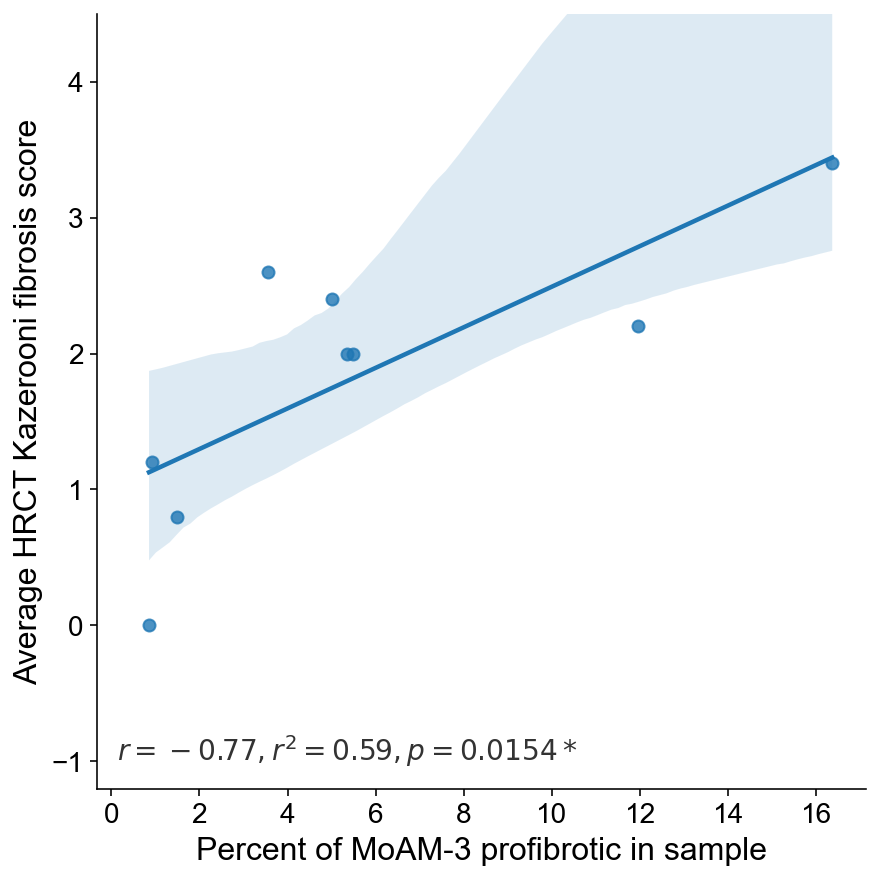

In [111]:
plot_df = df2.loc[df2.pft_test.isin(['k_score_fib']) & df2.cell_type.eq('MoAM-3 profibrotic')].copy()
plot_df.cell_type = plot_df.cell_type.cat.remove_unused_categories()

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

sns.regplot(
    data=plot_df,
    x="percent_in_sample",
    y="pft_measurement",
    ax=ax,
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Percent of MoAM-3 profibrotic in sample', fontsize=16)
ax.set_ylabel('Average HRCT Kazerooni fibrosis score', fontsize=16)
xmax = ax.get_xlim()[1]
ax.tick_params(labelleft=True, labelsize=14)
ax.set_xlim(-0.1 * (xmax / 8 + 1))
ax.set_ylim(-1.2, 4.5)
for i, pft in enumerate(['k_score_fib']):
    data = df.loc[(df.cell_type == c) & (df.pft_test == pft), :]
    x_fit = statsmodels.api.add_constant(data.percent_in_sample)
    res = statsmodels.api.OLS(data.pft_measurement, x_fit).fit()
    r = np.corrcoef(data.percent_in_sample, data.pft_measurement)[0, 1]
    lm_str = f"$r={r:.2f}, r^2={res.rsquared:.2f}, p={res.pvalues[1]:.4f}$"
    if res.pvalues[1] < 0.05:
        lm_str = lm_str[:-1] + "*$"
    ax.annotate(
        lm_str,
        (ax.get_xlim()[0], ax.get_ylim()[0]),
        (10, 14),
        textcoords="offset points",
        fontsize=14,
        color='#333'
    )
# axes.figure.subplots_adjust(hspace=0.3)
ax.figure.savefig('00_figures/Figure_3_panel_F_hrct_corr_ats.pdf')

## 2.3 Correlation between HRCT and PFT values

Invert PFT values for semantics: higher is worse

In [112]:
corr_pft_slice = pft_data[['fvc_pred', 'fev1_pred', 'dlco_pred', 'k_score_ggo', 'k_score_fib']].dropna()
for pft_meas in ['fvc_pred', 'fev1_pred', 'dlco_pred']:
    corr_pft_slice[pft_meas] = corr_pft_slice[pft_meas] * -1

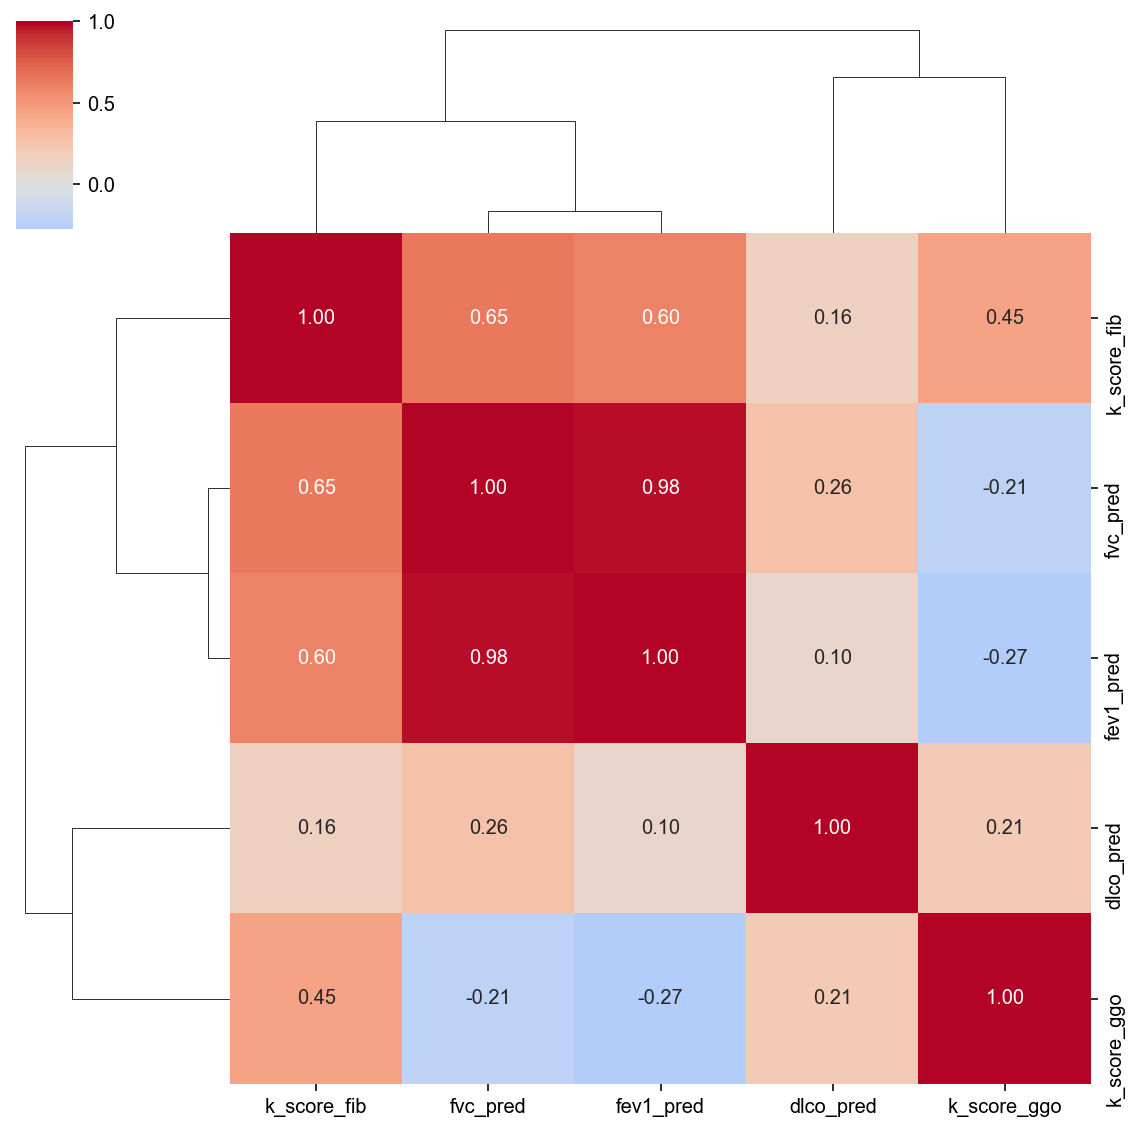

In [113]:
cor_mtx = corr_pft_slice.corr()
sns.clustermap(cor_mtx, cmap="coolwarm", annot=True, fmt=".2f", figsize=(8, 8), center=0)

In [114]:
print(f'Number of patients in the correlation analysis above: {corr_pft_slice.shape[0]}')

Number of patients in the correlation analysis above: 7


In [115]:
corr_pft_slice = pft_data[['fvc_pred', 'dlco_pred', 'k_score_ggo', 'k_score_fib']].dropna()
for pft_meas in ['fvc_pred', 'dlco_pred']:
    corr_pft_slice[pft_meas] = corr_pft_slice[pft_meas] * -1

In [116]:
corr_pft_slice = corr_pft_slice.rename(columns={
    'fvc_pred': 'FVC',
    'dlco_pred': 'DLCO',
    'k_score_ggo': 'GGO score',
    'k_score_fib': 'Fibrosis score'
})

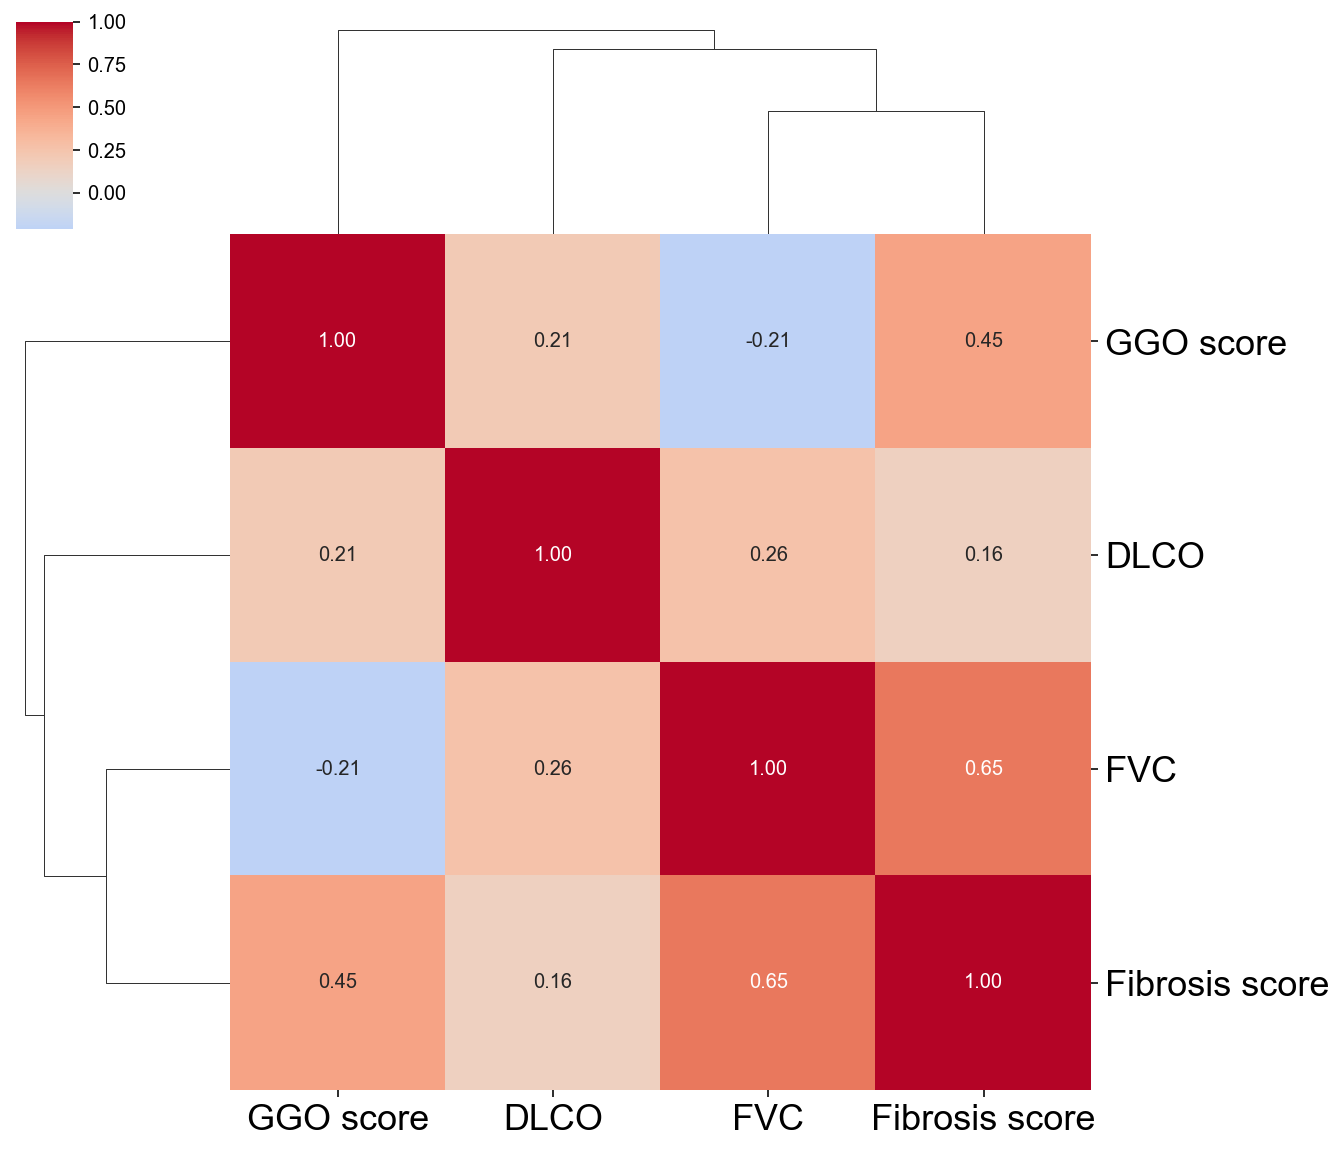

In [ ]:
cor_mtx = corr_pft_slice.corr()
cg = sns.clustermap(
    cor_mtx,
    cmap="coolwarm", annot=True, fmt=".2f", figsize=(8, 8), center=0)
cg.ax_heatmap.tick_params(labelsize=18)
cg.ax_heatmap.tick_params(axis='y', rotation=0)

In [118]:
print(f'Number of patients in the correlation analysis above: {corr_pft_slice.shape[0]}')

Number of patients in the correlation analysis above: 7


Now, exclude DLCO to get more data

In [119]:
corr_pft_slice = pft_data[['fvc_pred', 'k_score_ggo', 'k_score_fib']].dropna()
for pft_meas in ['fvc_pred']:
    corr_pft_slice[pft_meas] = corr_pft_slice[pft_meas] * -1

In [120]:
corr_pft_slice = corr_pft_slice.rename(columns={
    'fvc_pred': 'FVC',
    'k_score_ggo': 'GGO score',
    'k_score_fib': 'Fibrosis score'
})

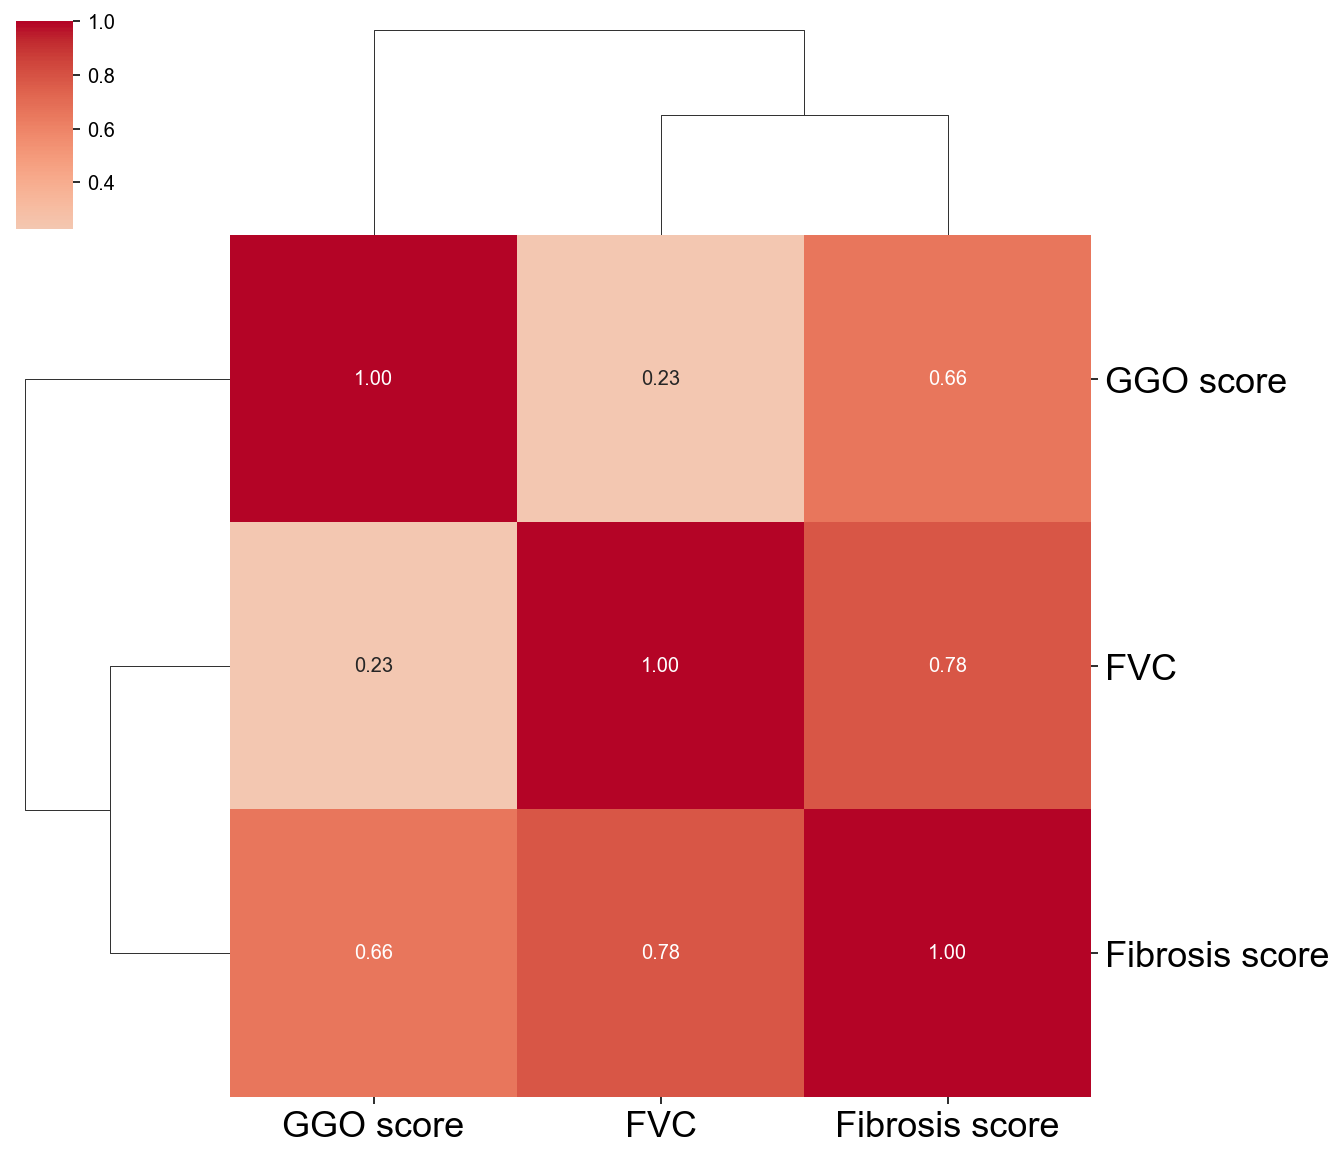

In [121]:
cor_mtx = corr_pft_slice.corr()
cg = sns.clustermap(cor_mtx, cmap="coolwarm", annot=True, fmt=".2f", figsize=(8, 8), center=0)
cg.ax_heatmap.tick_params(labelsize=18)
cg.ax_heatmap.tick_params(axis='y', rotation=0)

In [122]:
print(f'Number of patients in the correlation analysis above: {corr_pft_slice.shape[0]}')

Number of patients in the correlation analysis above: 9


## 3. IFN levels

In [14]:
cell_type_order = [
    'Monocytes',
    'Activated monocytes',
    'MoAM-1',
    'MoAM-2',
    'MoAM-3 profibrotic',
    'Interstitial macrophages',
    'TRAM-1',
    'TRAM-2',
    'TRAM-3',
    'TRAM-4',
    'TRAM-5 MT1G',
    'TRAM-6 activated',
    'Proliferating macrophages',

    'CD4 naive T cells',
    'CD4 TEM cells',
    'CD8 TEM cells',
    'CD8 TRM cells',
    'Tregs',
    'NK + γδT cells',

    'DC1',
    'DC2',
    'CCR7+ DC',
    'pDC',
    'B cells',
]

In [15]:
adata_ifn = adata[adata.obs.cell_type.isin(cell_type_order)].copy()

In [16]:
adata_ifn.obs.cell_type = adata_ifn.obs.cell_type.cat.reorder_categories(cell_type_order)

In [17]:
ifn_i = ['IFNA1', 'IFNA5', 'IFNB1', 'IFNE', 'IFNK']
ifn_ii = ['IFNG']
ifn_iii = ['IFNL1']

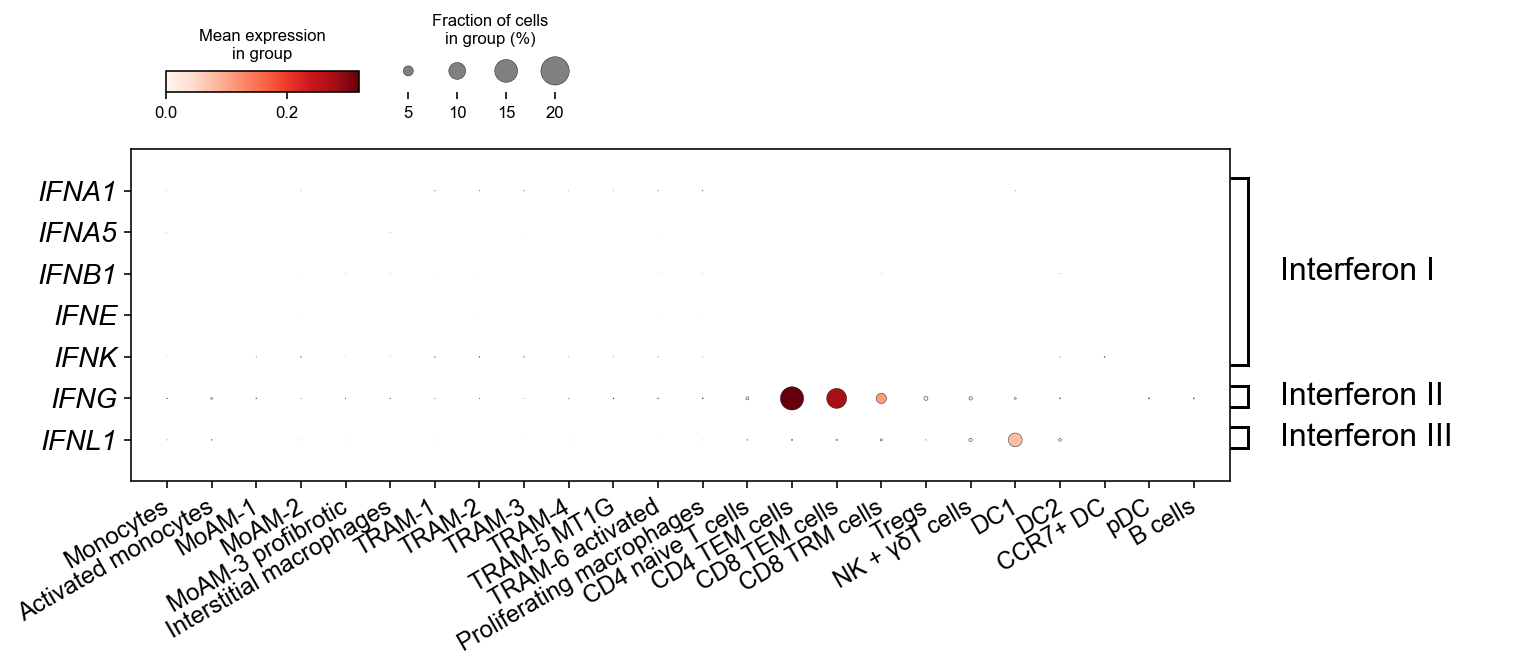

In [18]:
ifn_genes = {
    'Interferon I': ifn_i,
    'Interferon II': ifn_ii,
    'Interferon III': ifn_iii,
}
fig, ax = plt.subplots(figsize=(12, 5))
dp = sc.pl.DotPlot(
    adata_ifn,
    var_names=ifn_genes,
    groupby='cell_type',
    ax=ax,
    cmap='Reds'
)
dp.swap_axes()
axes = dp.get_axes()
axes['mainplot_ax'].tick_params(axis='y', labelsize=14)
axes['mainplot_ax'].set_xticklabels(
    axes['mainplot_ax'].get_xticklabels(),
    rotation=30,
    size=12,
    ha='right'
)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in axes['mainplot_ax'].get_xticklabels():
    t.set_transform(t.get_transform() + trans)
for t in axes['mainplot_ax'].get_yticklabels():
    t.set_fontstyle('italic')
for i, t in enumerate(axes['gene_group_ax'].texts):
    t.set_rotation(0)
    t.set_text(list(ifn_genes.keys())[i])
    t.set_ha('left')
    t.set_size(16)
axes['size_legend_ax'].figure.subplots_adjust(left=0.1, right=0.9, bottom=0.3)
main_p = axes['mainplot_ax'].get_position()
size_p = axes['size_legend_ax'].get_position()
color_p = axes['color_legend_ax'].get_position()
color_p.x1 = main_p.x0 + color_p.x1 - color_p.x0 + 0.02
color_p.x0 = main_p.x0 + 0.02
color_p.y1 = main_p.y1 + color_p.y1 - color_p.y0 + 0.08
color_p.y0 = main_p.y1 + 0.08
axes['color_legend_ax'].set_position(color_p)
size_p.x1 = color_p.x1 + 0.02 + size_p.x1 - size_p.x0
size_p.x0 = color_p.x1 + 0.02
size_p.y1 = main_p.y1 + size_p.y1 - size_p.y0 + 0.08
size_p.y0 = main_p.y1 + 0.08
axes['size_legend_ax'].set_position(size_p)
axes['size_legend_ax'].figure.savefig('00_figures/Figure_2E_ifn_expr.pdf', bbox_inches='tight')

## 4. Clinical correlation with IFN signatures per cell type

In [90]:
HALLMARK_IFN_ALPHA_R = json.loads(
    open('HALLMARK_INTERFERON_ALPHA_RESPONSE.v2023.2.Hs.json').read()
)['HALLMARK_INTERFERON_ALPHA_RESPONSE']['geneSymbols']

In [91]:
HALLMARK_IFN_GAMMA_R = json.loads(
    open('HALLMARK_INTERFERON_GAMMA_RESPONSE.v2023.2.Hs.json').read()
)['HALLMARK_INTERFERON_GAMMA_RESPONSE']['geneSymbols']

In [92]:
sc.tl.score_genes(adata, HALLMARK_IFN_ALPHA_R, ctrl_size=len(HALLMARK_IFN_ALPHA_R), score_name='HALLMARK_INTERFERON_ALPHA_RESPONSE', use_raw=True)
sc.tl.score_genes(adata, HALLMARK_IFN_GAMMA_R, ctrl_size=len(HALLMARK_IFN_GAMMA_R), score_name='HALLMARK_INTERFERON_GAMMA_RESPONSE', use_raw=True)

<AxesSubplot:title={'center':'HALLMARK_INTERFERON_GAMMA_RESPONSE'}, xlabel='UMAP1', ylabel='UMAP2'>

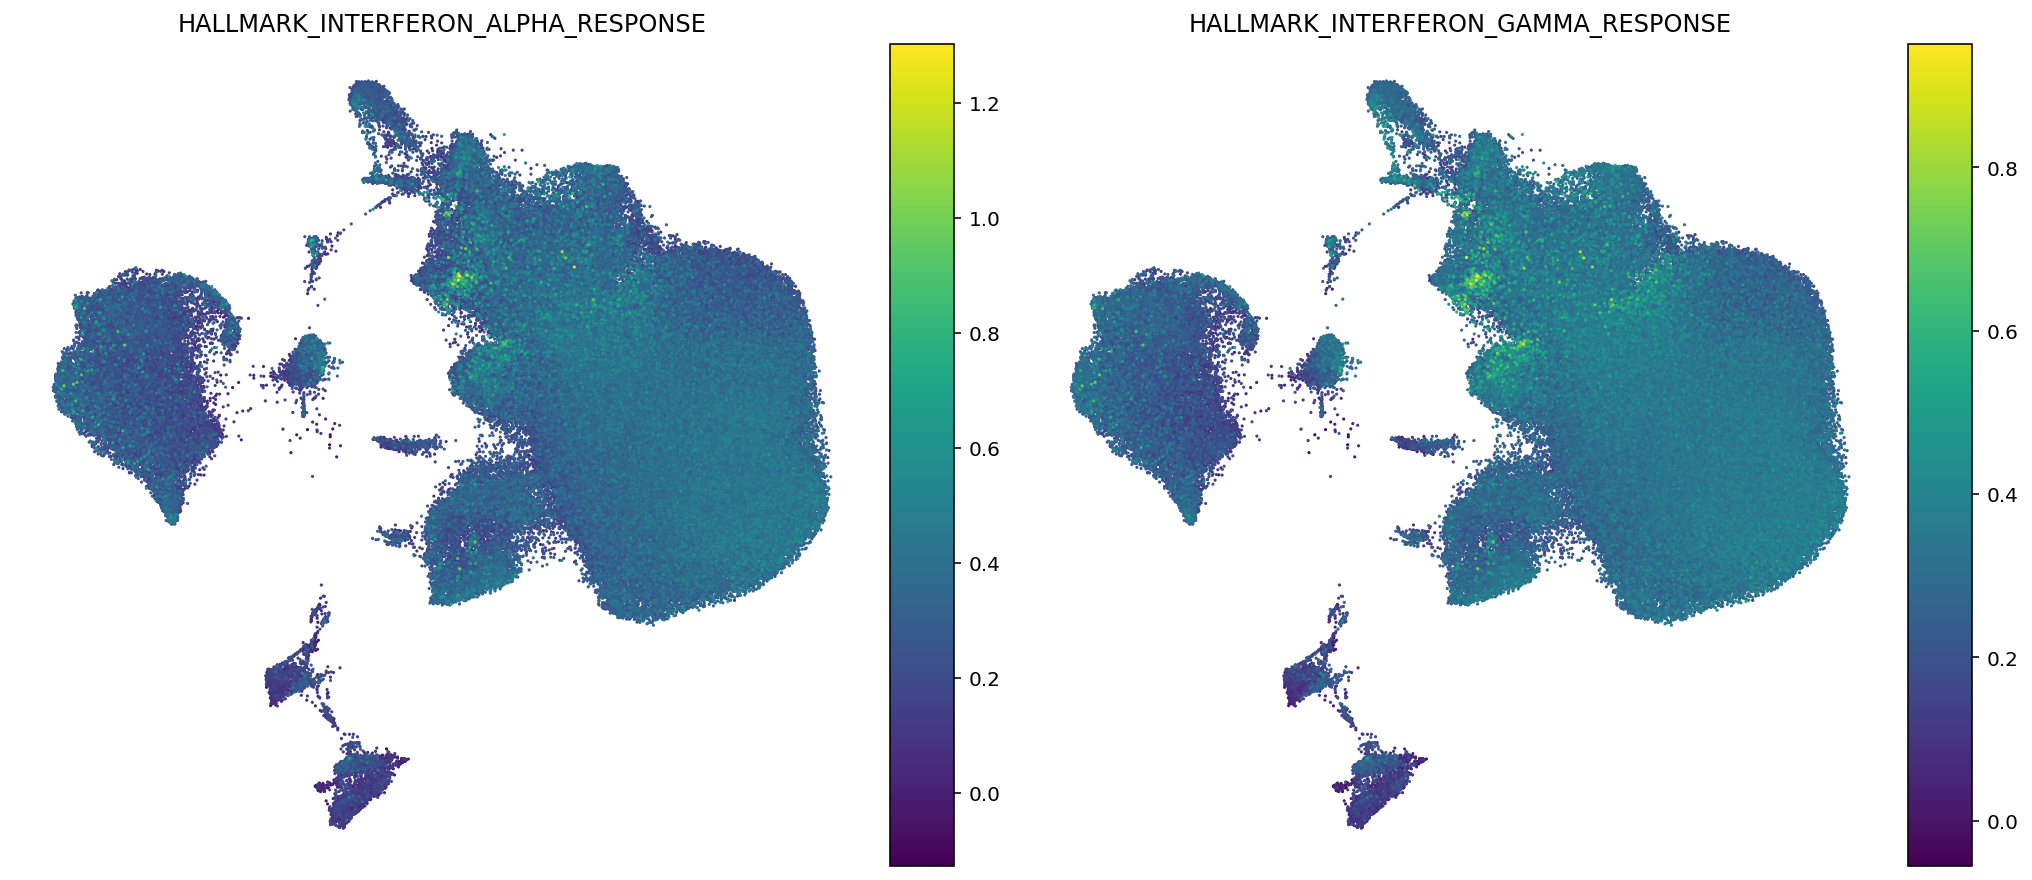

In [93]:
fig, axes = plt.subplots(figsize=(14, 6), ncols=2, constrained_layout=True)
sc.pl.umap(
    adata,
    color="HALLMARK_INTERFERON_ALPHA_RESPONSE",
    frameon=False,
    legend_loc="on data",
    show=False,
    size=10,
    ax=axes[0],
    legend_fontoutline=2,
    legend_fontsize=14,
)
sc.pl.umap(
    adata,
    color="HALLMARK_INTERFERON_GAMMA_RESPONSE",
    frameon=False,
    legend_loc="on data",
    show=False,
    size=10,
    ax=axes[1],
    legend_fontoutline=2,
    legend_fontsize=14,
)

In [94]:
ifn_resp_pseudobulk = adata.obs.groupby(['External Sample ID', 'cell_type']).agg({
    'HALLMARK_INTERFERON_ALPHA_RESPONSE': 'mean',
    'HALLMARK_INTERFERON_GAMMA_RESPONSE': 'mean',
}).reset_index()

In [95]:
ifng_resp_pseudobulk = ifn_resp_pseudobulk[
    ['External Sample ID', 'cell_type', 'HALLMARK_INTERFERON_GAMMA_RESPONSE']
].pivot(index='cell_type', columns='External Sample ID')

In [96]:
ifng_resp_pseudobulk.columns = ifng_resp_pseudobulk.columns.droplevel(0)

Text(0.5, 1.0, 'Average IFNG-response score')

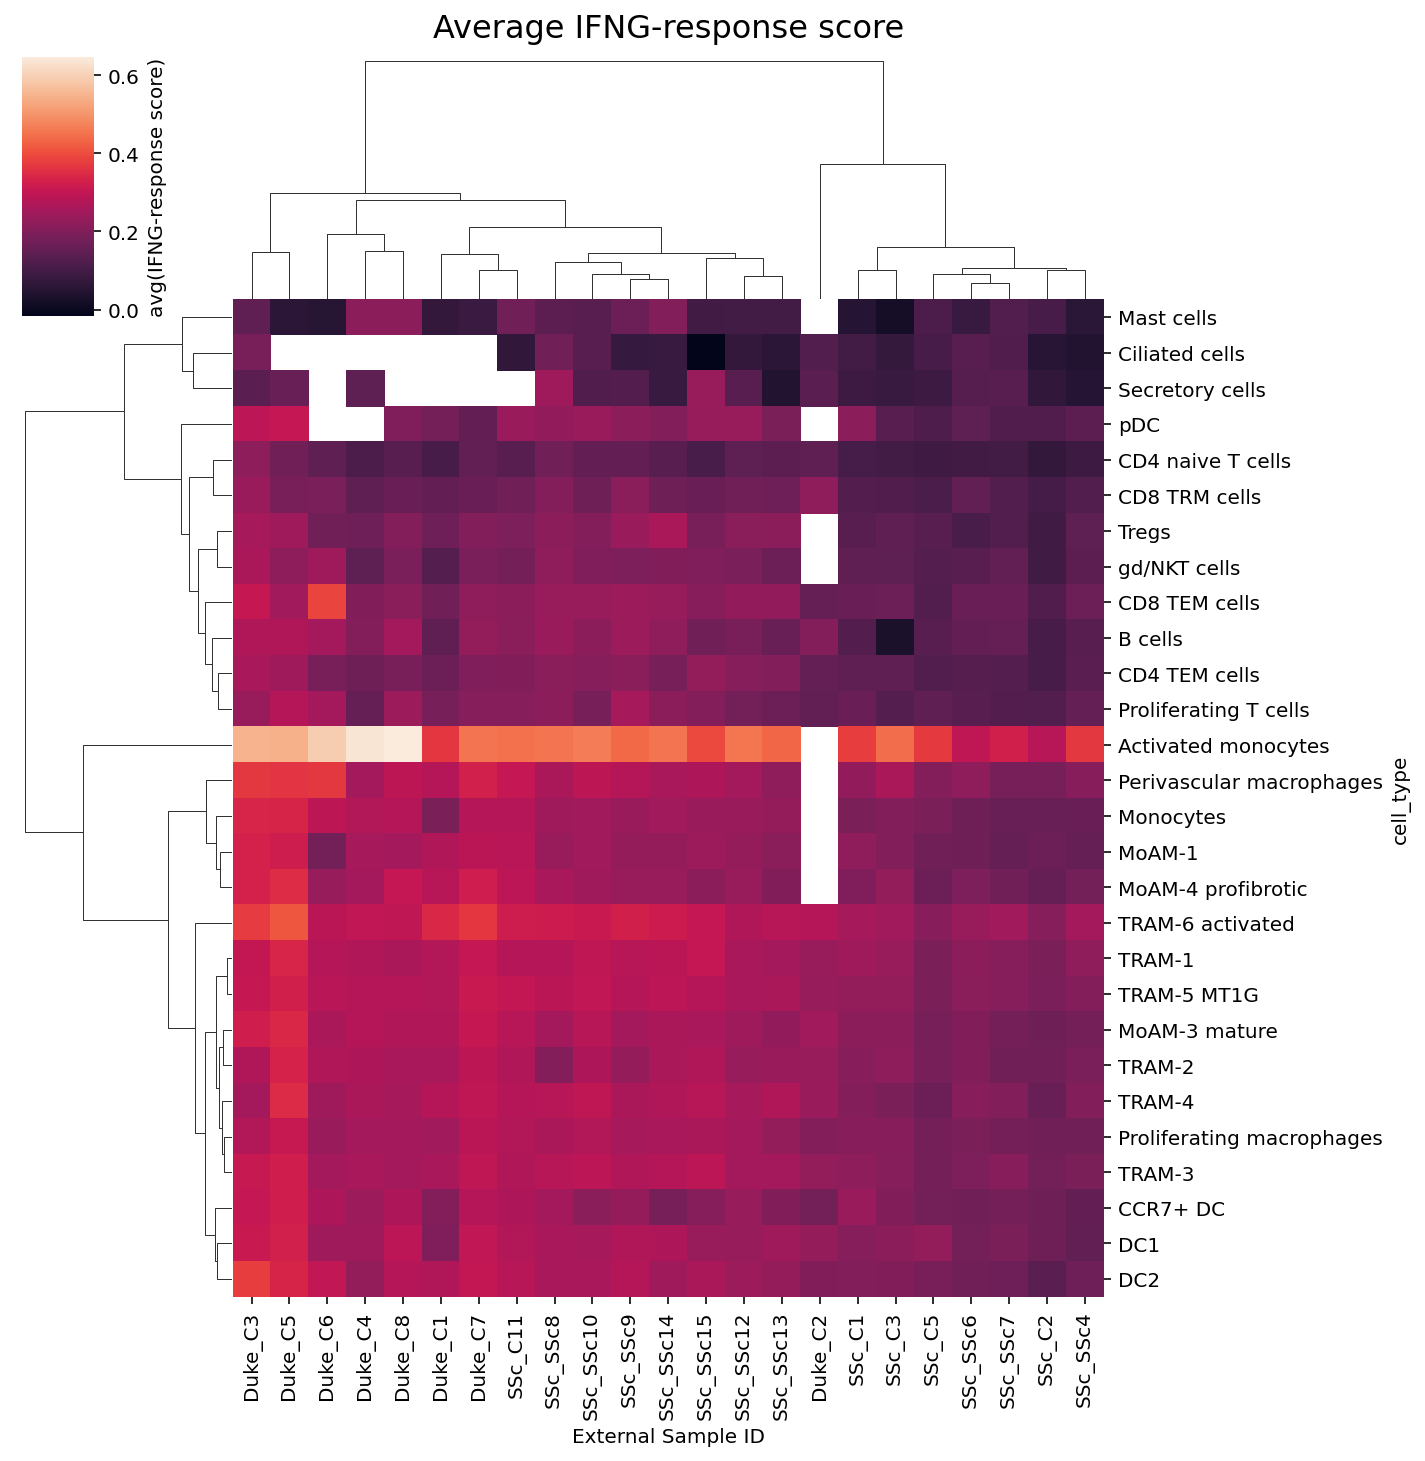

In [97]:
cg = sns.clustermap(
    ifng_resp_pseudobulk.fillna(0),
    mask=ifng_resp_pseudobulk.isna(),
    method='ward',
    cbar_kws=dict(
        label='avg(IFNG-response score)'
    ),
)
cg.ax_col_dendrogram.set_title('Average IFNG-response score', size=16)

In [98]:
ifna_resp_pseudobulk = ifn_resp_pseudobulk[
    ['External Sample ID', 'cell_type', 'HALLMARK_INTERFERON_ALPHA_RESPONSE']
].pivot(index='cell_type', columns='External Sample ID')

In [99]:
ifna_resp_pseudobulk.columns = ifna_resp_pseudobulk.columns.droplevel(0)

Text(0.5, 1.0, 'Average IFNA-response score')

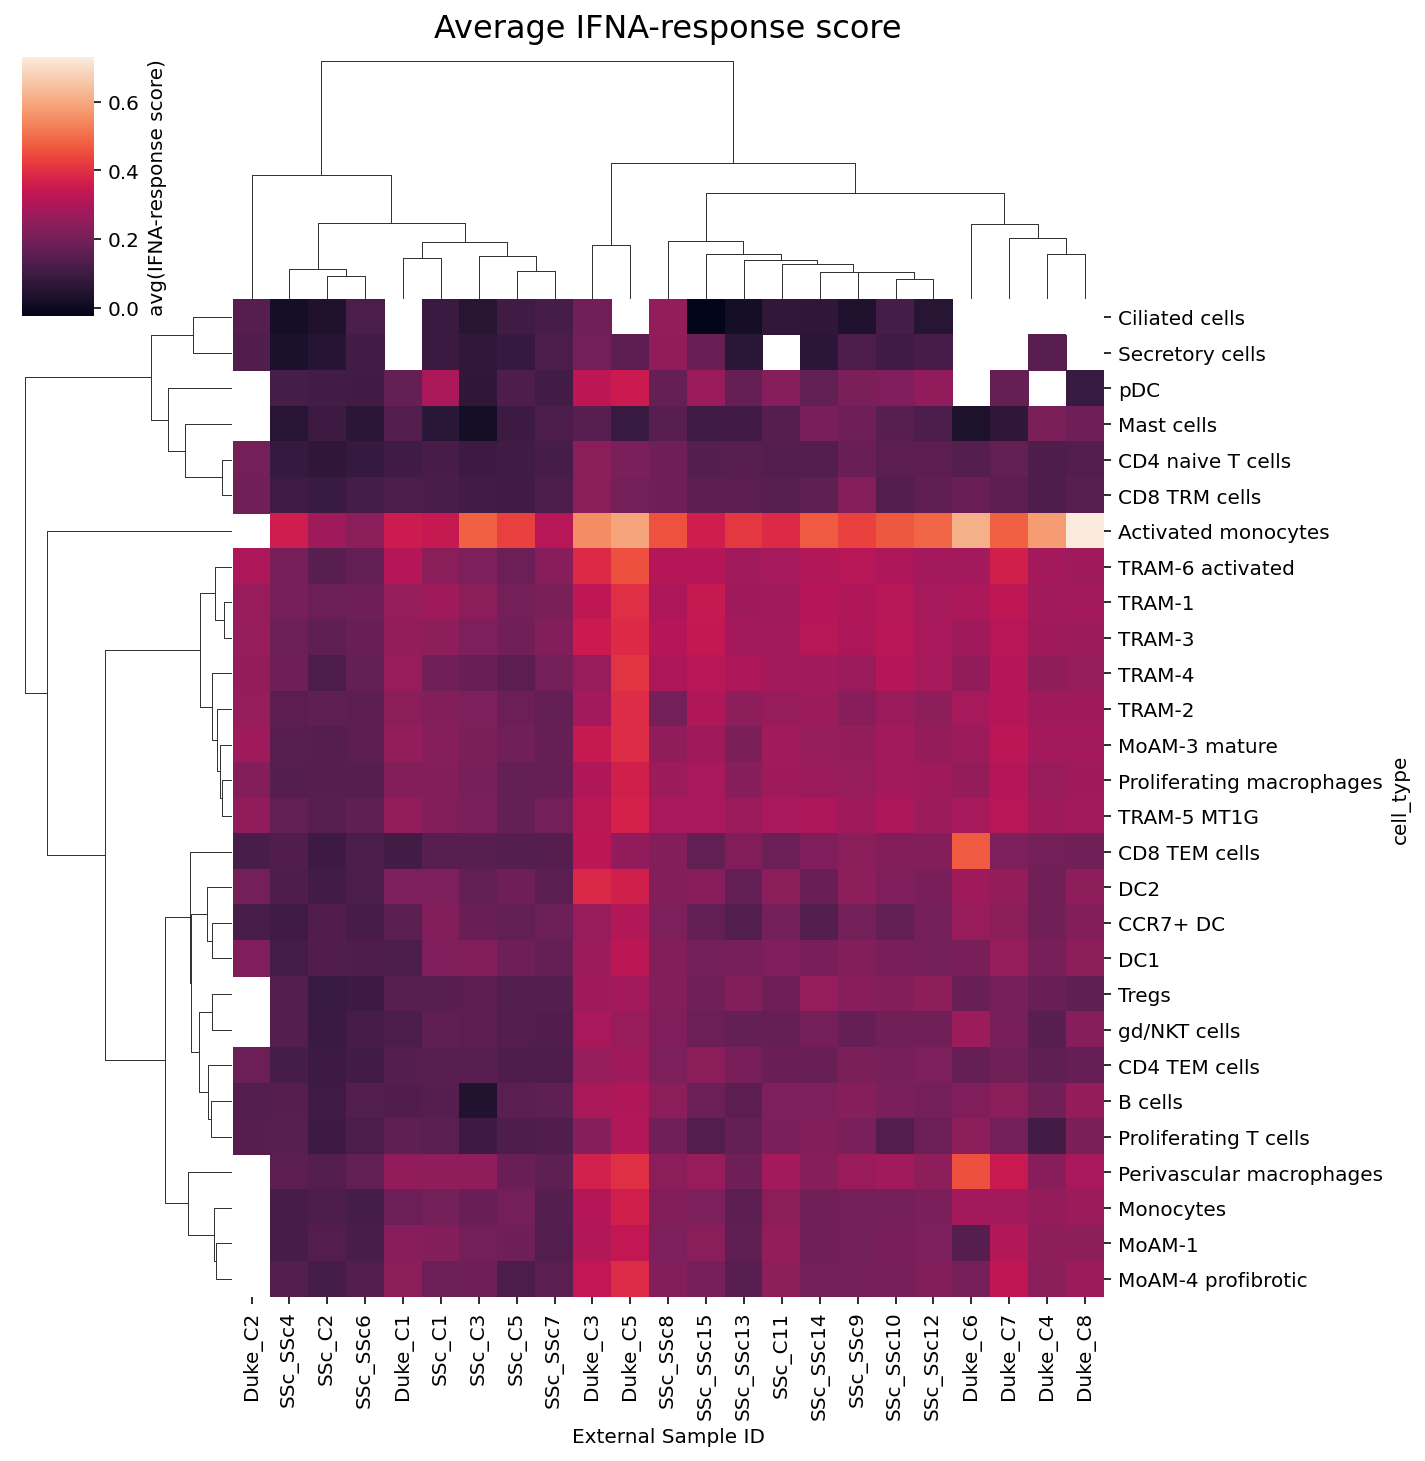

In [100]:
cg = sns.clustermap(
    ifna_resp_pseudobulk.fillna(0),
    mask=ifna_resp_pseudobulk.isna(),
    method='ward',
    cbar_kws=dict(
        label='avg(IFNA-response score)'
    ),
)
cg.ax_col_dendrogram.set_title('Average IFNA-response score', size=16)

In [101]:
ifn_resp_pseudobulk.columns

Index(['External Sample ID', 'cell_type', 'HALLMARK_INTERFERON_ALPHA_RESPONSE',
       'HALLMARK_INTERFERON_GAMMA_RESPONSE'],
      dtype='object')

In [102]:
df = counts.loc[counts.cell_type.isin(clusters), :].copy()

In [106]:
ssc_samples = samples['External Sample ID'][samples.Status.eq('SSc') & samples.Study.eq('this')]

In [107]:
df = df.loc[df["External Sample ID"].isin(ssc_samples)].copy()

In [108]:
df.cell_type = df.cell_type.cat.remove_unused_categories()

In [109]:
sample_id_to_sample = samples.loc[:, ["External Sample ID", "Sample"]].set_index("External Sample ID").Sample

In [110]:
df["Sample"] = sample_id_to_sample[df["External Sample ID"]].values

In [111]:
df.shape

(110, 7)

In [112]:
df = df.merge(pft_data, left_on="Sample", right_on='study_code')

In [113]:
df.shape

(99, 14)

In [116]:
ssc_samples[~ssc_samples.isin(df['External Sample ID'])]

7    SSc_SSc8
Name: External Sample ID, dtype: object

# 4. Correlation with genes

In [43]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [44]:
BASE = DATA / 'pseudobulk-gsva'

In [46]:
%%time
data = {}
for ct in sorted(os.listdir(BASE)):
    if not (BASE / ct / 'data' / 'transformed.tsv').exists():
        print(f'{ct} does not have counts')
        continue
    pseudobulk = pd.read_table(BASE / ct / 'data' / 'transformed.tsv', delim_whitespace=True).T
    metadata = pd.read_csv(BASE / ct / 'data' / f'{ct}-meta.csv', index_col=0)
    metadata.index = metadata.index.str.replace(r'\_[ATCG]+$', '', regex=True)
    metadata = metadata.merge(
        clinical_data[['External Sample ID', 'fvc_pred', 'mmf', 'k_score_fib']],
        on='External Sample ID',
        how='left'
    )
    # Copy value for SSc8 from SSc6 (repeat sample)
    metadata.loc[metadata['External Sample ID'].eq('SSc_SSc8'), 'mmf'] = 'Naive'
    data[ct] = {
        'expr': pseudobulk,
        'meta': metadata
    }

.DS_Store does not have counts
._.DS_Store does not have counts
Activated_monocytes does not have counts
Ciliated_cells does not have counts
Mast_cells does not have counts
Proliferating_T_cells does not have counts
Secretory_cells does not have counts
pDC does not have counts
CPU times: user 1.45 s, sys: 49 ms, total: 1.5 s
Wall time: 2.24 s


In [47]:
stats = []
for ct in data.keys():
    expr = data[ct]['expr']
    meta = data[ct]['meta'].set_index('External Sample ID')
    df = expr[['TNFSF15']].copy()
    df = df.merge(meta[['fvc_pred', 'k_score_fib']], left_index=True, right_index=True)
    df = df.loc[df.fvc_pred.notna()]
    res = scipy.stats.pearsonr(df.TNFSF15, df.fvc_pred)
    stats.append((ct, res[0], res[1]))
    # break
stats = pd.DataFrame(stats, columns=['cell_type', 'pearson_r', 'pval'])
stats = stats.dropna()
#stats.loc[stats.pval.eq(0), 'pval'] = stats.pval[stats.pval.gt(0)].min() * 0.1
stats['padj'] = statsmodels.stats.multitest.fdrcorrection(stats.pval)[1]

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [48]:
stats

cell_type  pearson_r      pval      padj
0                     B_cells   0.129864  0.739133  0.788943
1                    CCR7+_DC  -0.345197  0.502771  0.657470
6                         DC1  -0.683839  0.042229  0.143578
7                         DC2  -0.343823  0.250034  0.386416
8                      MoAM-1  -0.616692  0.024772  0.105282
9               MoAM-3_mature  -0.648013  0.003635  0.030896
10         MoAM-4_profibrotic  -0.475675  0.118043  0.250841
11                  Monocytes  -0.498448  0.099068  0.240593
12   Perivascular_macrophages  -0.101058  0.742534  0.788943
13  Proliferating_macrophages  -0.322232  0.207174  0.352196
14                     TRAM-1  -0.575624  0.012430  0.070438
15                     TRAM-2   0.443591  0.074495  0.211069
16                     TRAM-3  -0.363535  0.138098  0.260853
17                     TRAM-4  -0.035160  0.889841  0.889841
18                TRAM-5_MT1G  -0.209279  0.404597  0.573179
19           TRAM-6_activated  -0.141552  0.587873  0.713845
22                     global  -0.767640  0.000200  0.003398

Text(0, 0.5, 'FVC')

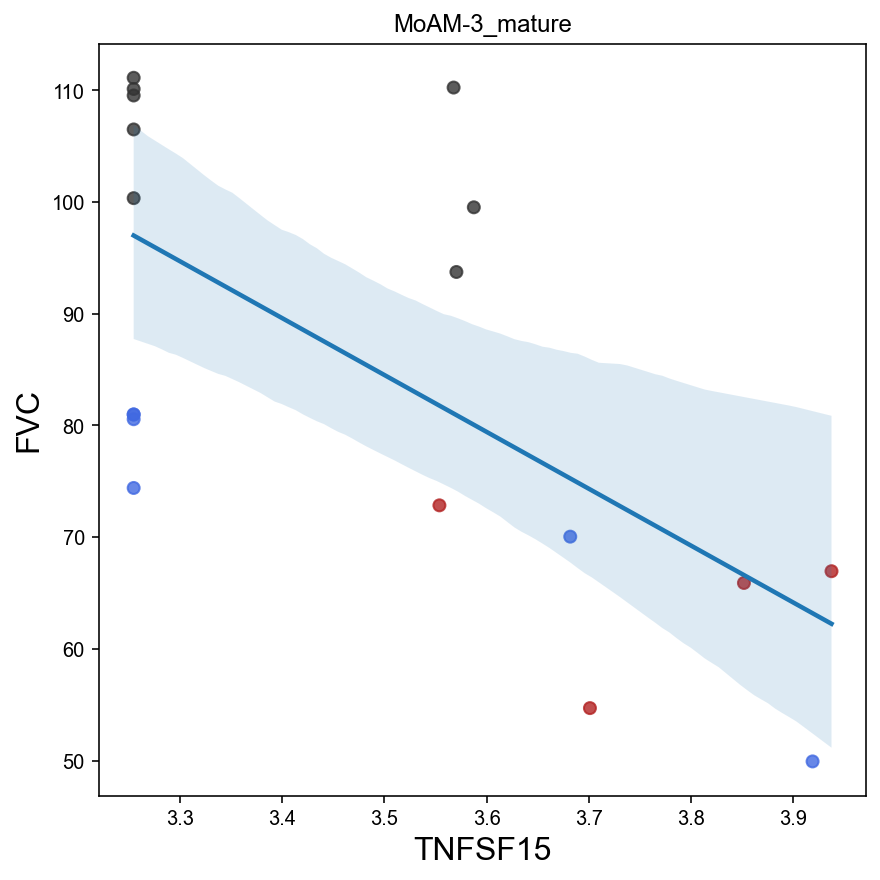

In [49]:
ct = 'MoAM-3_mature'
expr = data[ct]['expr']
meta = data[ct]['meta'].set_index('External Sample ID')
df = expr[['TNFSF15']].copy()
df = df.merge(meta[['fvc_pred', 'k_score_fib', 'mmf']], left_index=True, right_index=True)
df = df.loc[df.fvc_pred.notna()]
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
sns.regplot(
    data=df,
    x='TNFSF15',
    y='fvc_pred',
    scatter_kws={
        'color': [
            mpl.colors.to_rgb(x)
            for x in df.mmf.map({'Naive': 'royalblue', 'MMF': 'firebrick'}).fillna('#333')
        ]
    },
    ax=ax
)
ax.set_title(ct)
ax.set_xlabel('TNFSF15', size=16)
ax.set_ylabel('FVC', size=16)

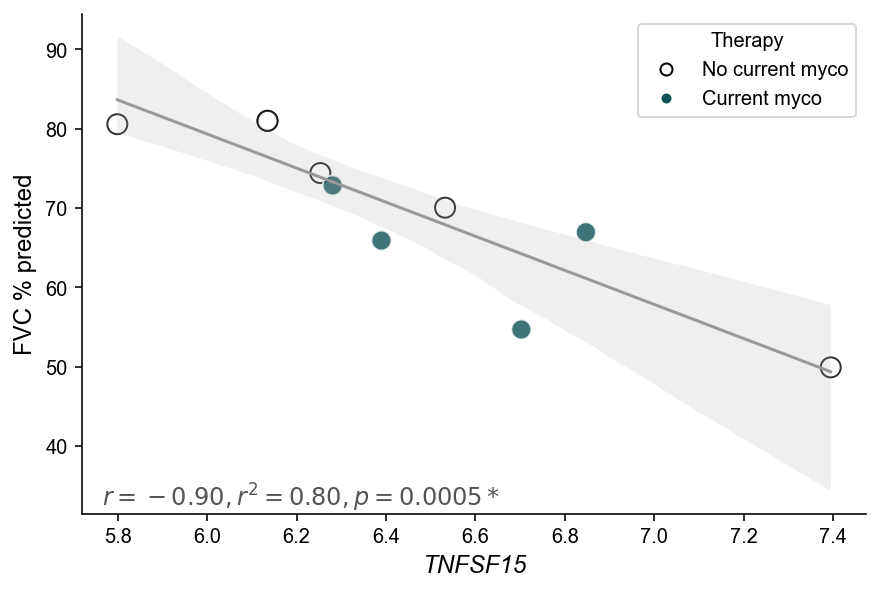

In [ ]:
ct = 'global'
expr = data[ct]['expr']
meta = data[ct]['meta'].set_index('External Sample ID')
df = expr[['TNFSF15']].copy()
df = df.merge(meta[['fvc_pred', 'k_score_fib', 'mmf']], left_index=True, right_index=True)
df = df.loc[df.fvc_pred.notna()]
df = df.loc[df.mmf.notna()]
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
sns.regplot(
    data=df,
    x='TNFSF15',
    y='fvc_pred',
    scatter_kws={
        'color': [
            mpl.colors.to_rgb(x)
            for x in df.mmf.map({'Naive': 'white', 'MMF': '#0f5356'}).fillna('#333')
        ],
        'ec': [
            mpl.colors.to_rgb(x)
            for x in df.mmf.map({'Naive': 'k', 'MMF': 'w'})
        ],
        's': 100
    },
    line_kws={'color': '#999', 'lw': 1.5},
    ax=ax
)
ax.set_xlabel("TNFSF15", fontsize=12, style='italic')
ax.set_ylabel("FVC % predicted", fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(
    handles=[
        mpl.lines.Line2D(
            [0], [0], marker='o', markerfacecolor='white',
            label='No current myco', markeredgecolor='k',
            color='#ffffffff'
        ),
        mpl.lines.Line2D(
            [0], [0], marker='o', markerfacecolor='#0f5356',
            label='Current myco',
            color='#ffffffff'
        )
    ],
    loc='upper right',
    # bbox_to_anchor=(1.05, -0.01),
    title='Therapy',
    ncol=1
)

x_fit = statsmodels.api.add_constant(df.TNFSF15)
res = statsmodels.api.OLS(df.fvc_pred, x_fit).fit()
r = np.corrcoef(df.TNFSF15, df.fvc_pred)[0, 1]
lm_str = f"$r={r:.2f}, r^2={res.rsquared:.2f}, p={res.pvalues[1]:.4f}$"
if res.pvalues[1] < 0.05:
    lm_str = lm_str[:-1] + "*$"
ax.annotate(
    lm_str,
    (ax.get_xlim()[0], ax.get_ylim()[0]),
    (10, 4),
    textcoords="offset points",
    fontsize=12,
    color='#555'
)

fig.savefig('00_figures/Figure_8C_fvc_vs_tnfsf15.pdf')

In [52]:
df

TNFSF15    fvc_pred  k_score_fib    mmf
SSc_SSc4   6.252927   74.406565          0.8  Naive
SSc_SSc6   6.134580   80.987043          0.0  Naive
SSc_SSc7   5.798664   80.562132          1.2  Naive
SSc_SSc8   6.134800   80.987043          0.0  Naive
SSc_SSc9   7.395058   49.922879          3.4  Naive
SSc_SSc10  6.532067   70.047361          2.6  Naive
SSc_SSc12  6.280556   72.850001          2.4    MMF
SSc_SSc13  6.702635   54.696651          2.2    MMF
SSc_SSc14  6.847232   66.953562          2.0    MMF
SSc_SSc15  6.389669   65.901154          2.0    MMF
Duke_C1    5.797005  110.130689          NaN    NaN
Duke_C2    6.356073  111.132097          NaN    NaN
Duke_C3    5.879687  110.257333          NaN    NaN
Duke_C4    6.041377   93.744917          NaN    NaN
Duke_C5    5.720479   99.535300          NaN    NaN
Duke_C6    6.099196  109.547334          NaN    NaN
Duke_C7    5.860859  106.506408          NaN    NaN
Duke_C8    5.662966  100.355287          NaN    NaN

In [129]:
stats = []
for ct in data.keys():
    expr = data[ct]['expr']
    meta = data[ct]['meta'].set_index('External Sample ID')
    df = expr[['TNFSF15']].copy()
    df = df.merge(meta[['fvc_pred', 'k_score_fib']], left_index=True, right_index=True)
    df = df.loc[df.k_score_fib.notna()]
    res = scipy.stats.pearsonr(df.TNFSF15, df.k_score_fib)
    stats.append((ct, res[0], res[1]))
    # break
stats = pd.DataFrame(stats, columns=['cell_type', 'pearson_r', 'pval'])
stats = stats.dropna()
#stats.loc[stats.pval.eq(0), 'pval'] = stats.pval[stats.pval.gt(0)].min() * 0.1
stats['padj'] = statsmodels.stats.multitest.fdrcorrection(stats.pval)[1]

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/venv/lib/python3.9/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [130]:
stats

cell_type  pearson_r      pval      padj
0                     B_cells  -0.504129  0.202700  0.382878
1                    CCR7+_DC   0.830159  0.081849  0.173928
6                         DC1   0.419808  0.348416  0.493589
7                         DC2   0.648789  0.042411  0.144196
8                      MoAM-1   0.781147  0.007634  0.064886
9               MoAM-3_mature   0.830398  0.002934  0.049878
10         MoAM-4_profibrotic   0.066479  0.855219  0.867126
11                  Monocytes   0.143024  0.693456  0.785917
12   Perivascular_macrophages   0.629406  0.051190  0.145039
13  Proliferating_macrophages   0.372780  0.288727  0.446215
14                     TRAM-1   0.658811  0.038296  0.144196
15                     TRAM-2  -0.198410  0.608829  0.739292
16                     TRAM-3   0.587262  0.074256  0.173928
17                     TRAM-4  -0.283623  0.427120  0.558541
18                TRAM-5_MT1G   0.374382  0.286495  0.446215
19           TRAM-6_activated  -0.060968  0.867126  0.867126
22                     global   0.737782  0.014860  0.084206

Text(0, 0.5, 'Fibrosis score')

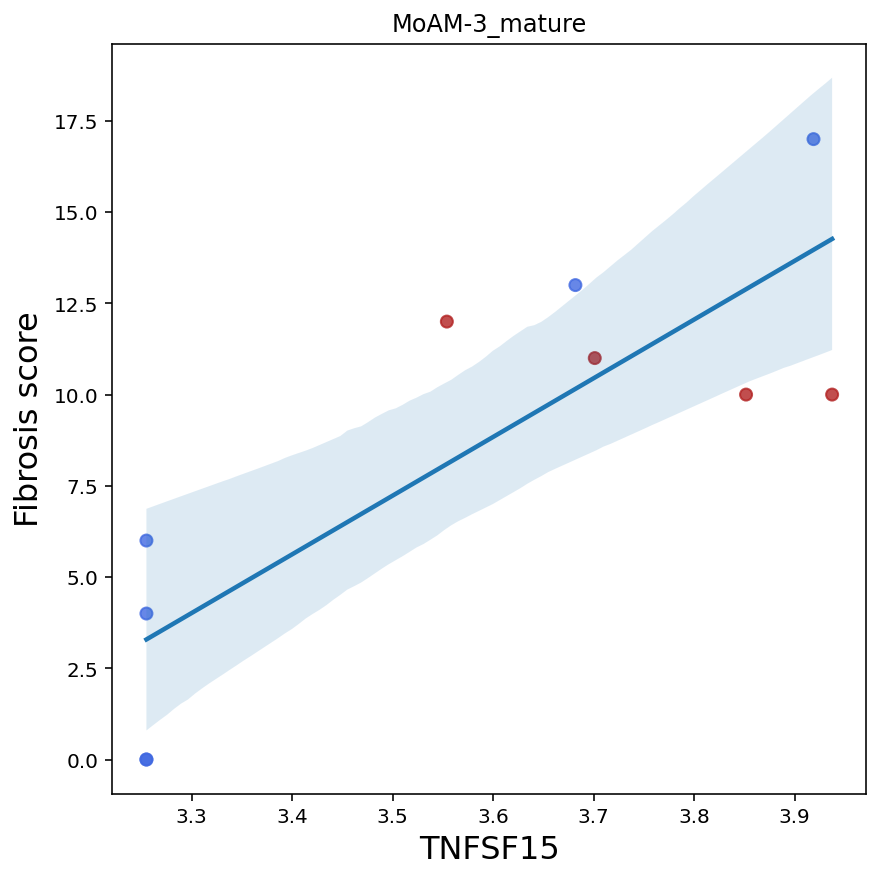

In [134]:
ct = 'MoAM-3_mature'
expr = data[ct]['expr']
meta = data[ct]['meta'].set_index('External Sample ID')
df = expr[['TNFSF15']].copy()
df = df.merge(meta[['fvc_pred', 'k_score_fib', 'mmf']], left_index=True, right_index=True)
df = df.loc[df.k_score_fib.notna()]
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
sns.regplot(
    data=df,
    x='TNFSF15',
    y='k_score_fib',
    scatter_kws={
        'color': [
            mpl.colors.to_rgb(x)
            for x in df.mmf.map({'Naive': 'royalblue', 'MMF': 'firebrick'}).fillna('#333')
        ]
    },
    ax=ax
)
ax.set_title(ct)
ax.set_xlabel('TNFSF15', size=16)
ax.set_ylabel('Fibrosis score', size=16)